<a id = "2"></a><br>
# Load Python Pakages


In [1]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.preprocessing import QuantileTransformer, quantile_transform

#statistics
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p


#feature engineering
from sklearn.feature_selection import mutual_info_classif


#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config


#algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC


#model evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, f1_score, fbeta_score, auc, balanced_accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, RocCurveDisplay, confusion_matrix, recall_score

# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# Dealing with imbalanced target
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

random_state = 100


<a id = "3"></a><br>
#  First look to data

In [2]:
# Read the data
original_train_df = pd.read_csv('data.csv',  index_col='ID')

# reserved 
pipe_data = original_train_df.copy()

# use for analysis
train_df = original_train_df.copy()
train_df.head()

Age  Sex  Education     BMI Physical_activity_level  HgbA1C  \
ID                                                                   
10001   53    1          9  26.533                                   
10002   60    1         12                             585           
10004   69    1         12  21.427                          6.4952   
10005   70    2          5  26.508                    1680           
10006   51    2          6  26.892                           6.242   

      Total_cholesterol blood_triglycerids blood_HDL blood_LDL  ...  \
ID                                                              ...   
10001                                                           ...   
10002                                   92        38        50  ...   
10004               106                                         ...   
10005                                  187        39       147  ...   
10006               223                                         ...   

      DelayedRecall delayed_repet delayed_intrus Processing_speed Reasoning  \
ID                                                                            
10001                                                                         
10002             0             0              1               45         4   
10004                                                                         
10005             3             0              1               30         0   
10006                                                                         

      Category_fluency fluency_repet fluency_intrus Working_memory   SGST  
ID                                                                         
10001                                                                      
10002               14             0              0              4  1.013  
10004                                                                      
10005               10             0              0              2  1.196  
10006                                                                      

[5 rows x 46 columns]

In [3]:
train_df.shape

(7108, 46)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7108 entries, 10001 to 19193
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             7108 non-null   int64 
 1   Sex                             7108 non-null   int64 
 2   Education                       7108 non-null   int64 
 3   BMI                             7108 non-null   object
 4   Physical_activity_level         7108 non-null   object
 5   HgbA1C                          7108 non-null   object
 6   Total_cholesterol               7108 non-null   object
 7   blood_triglycerids              7108 non-null   object
 8   blood_HDL                       7108 non-null   object
 9   blood_LDL                       7108 non-null   object
 10  total_HDL_ratio                 7108 non-null   object
 11  blood_creatinine                7108 non-null   object
 12  blood_DHEA_S                    7108 non-nu

There are some empty entries, but they are not recognized as nan. Also, numerical columns are identified as objects. Let's correct these issues. 

In [5]:
train_df = train_df.replace(r'^\s*$', np.nan, regex=True)
features_need_type_change = train_df.select_dtypes(include='object').columns
train_df[features_need_type_change] = train_df[features_need_type_change].astype("float")
train_df = train_df.drop(train_df[train_df['Sex'] == 8].index)
train_df['Sex'] = train_df['Sex'].astype('category')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7027 entries, 10001 to 19193
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Age                             7027 non-null   int64   
 1   Sex                             7027 non-null   category
 2   Education                       7027 non-null   int64   
 3   BMI                             6325 non-null   float64 
 4   Physical_activity_level         1052 non-null   float64 
 5   HgbA1C                          1052 non-null   float64 
 6   Total_cholesterol               1052 non-null   float64 
 7   blood_triglycerids              1052 non-null   float64 
 8   blood_HDL                       1052 non-null   float64 
 9   blood_LDL                       1052 non-null   float64 
 10  total_HDL_ratio                 1052 non-null   float64 
 11  blood_creatinine                1052 non-null   float64 
 12  blood_DHEA_S   

## Missing values

In [6]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

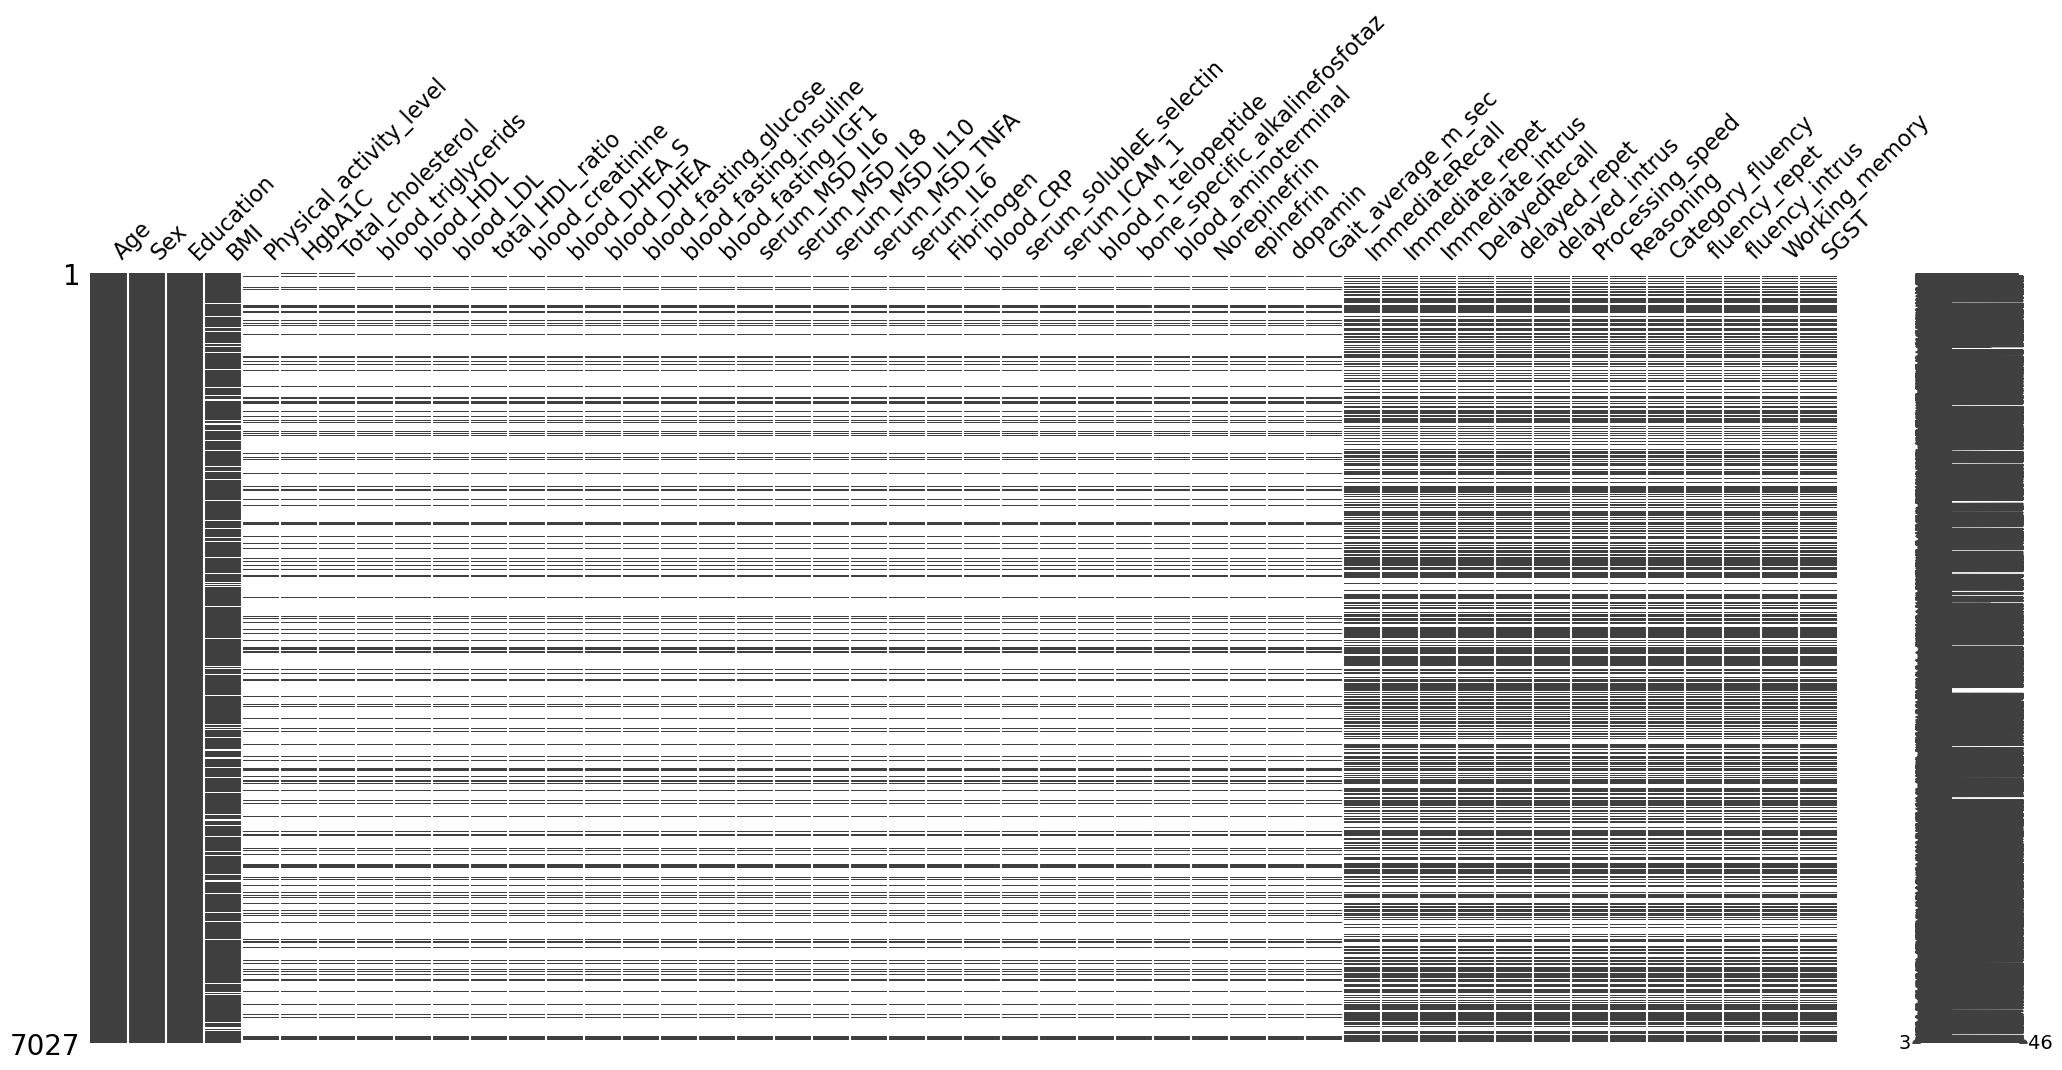

In [7]:
import missingno as msno
%matplotlib inline
msno.matrix(train_df)
plt.show()

There are many missing values. But our target will be Gait_average_m_sec. Let's start with dropping missing values on Gait_average_m_sec.

In [8]:
train_df = train_df.dropna(subset=['Gait_average_m_sec'])

Let's observe missing values again.

In [9]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

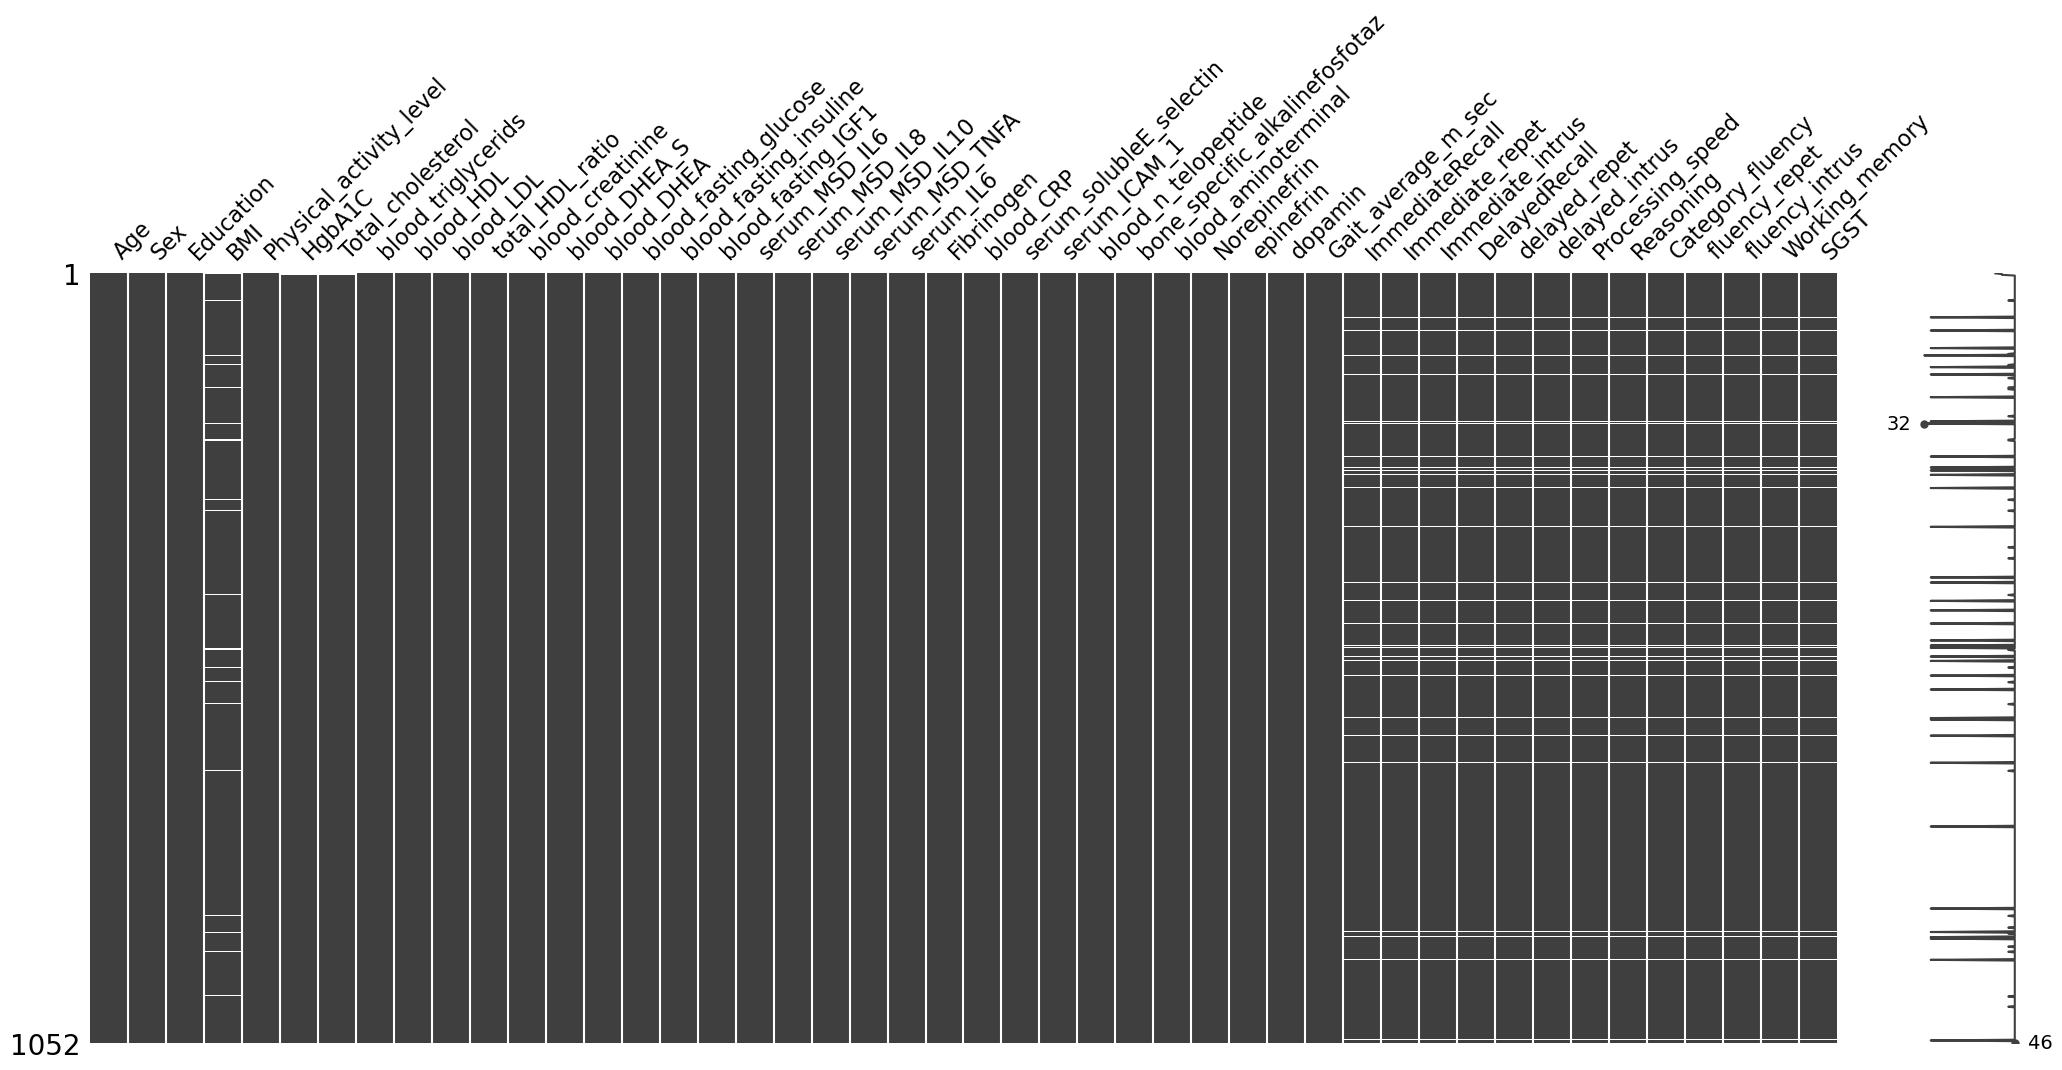

In [10]:
msno.matrix(train_df)
plt.show()

There are records that we have no cognitive data. I will also drop them.

In [11]:
train_df = train_df.dropna(subset=['Immediate_repet'])

In [12]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["percent"] = missing[0:] / 7108 *100
missing.style.background_gradient('viridis')

<Axes: >

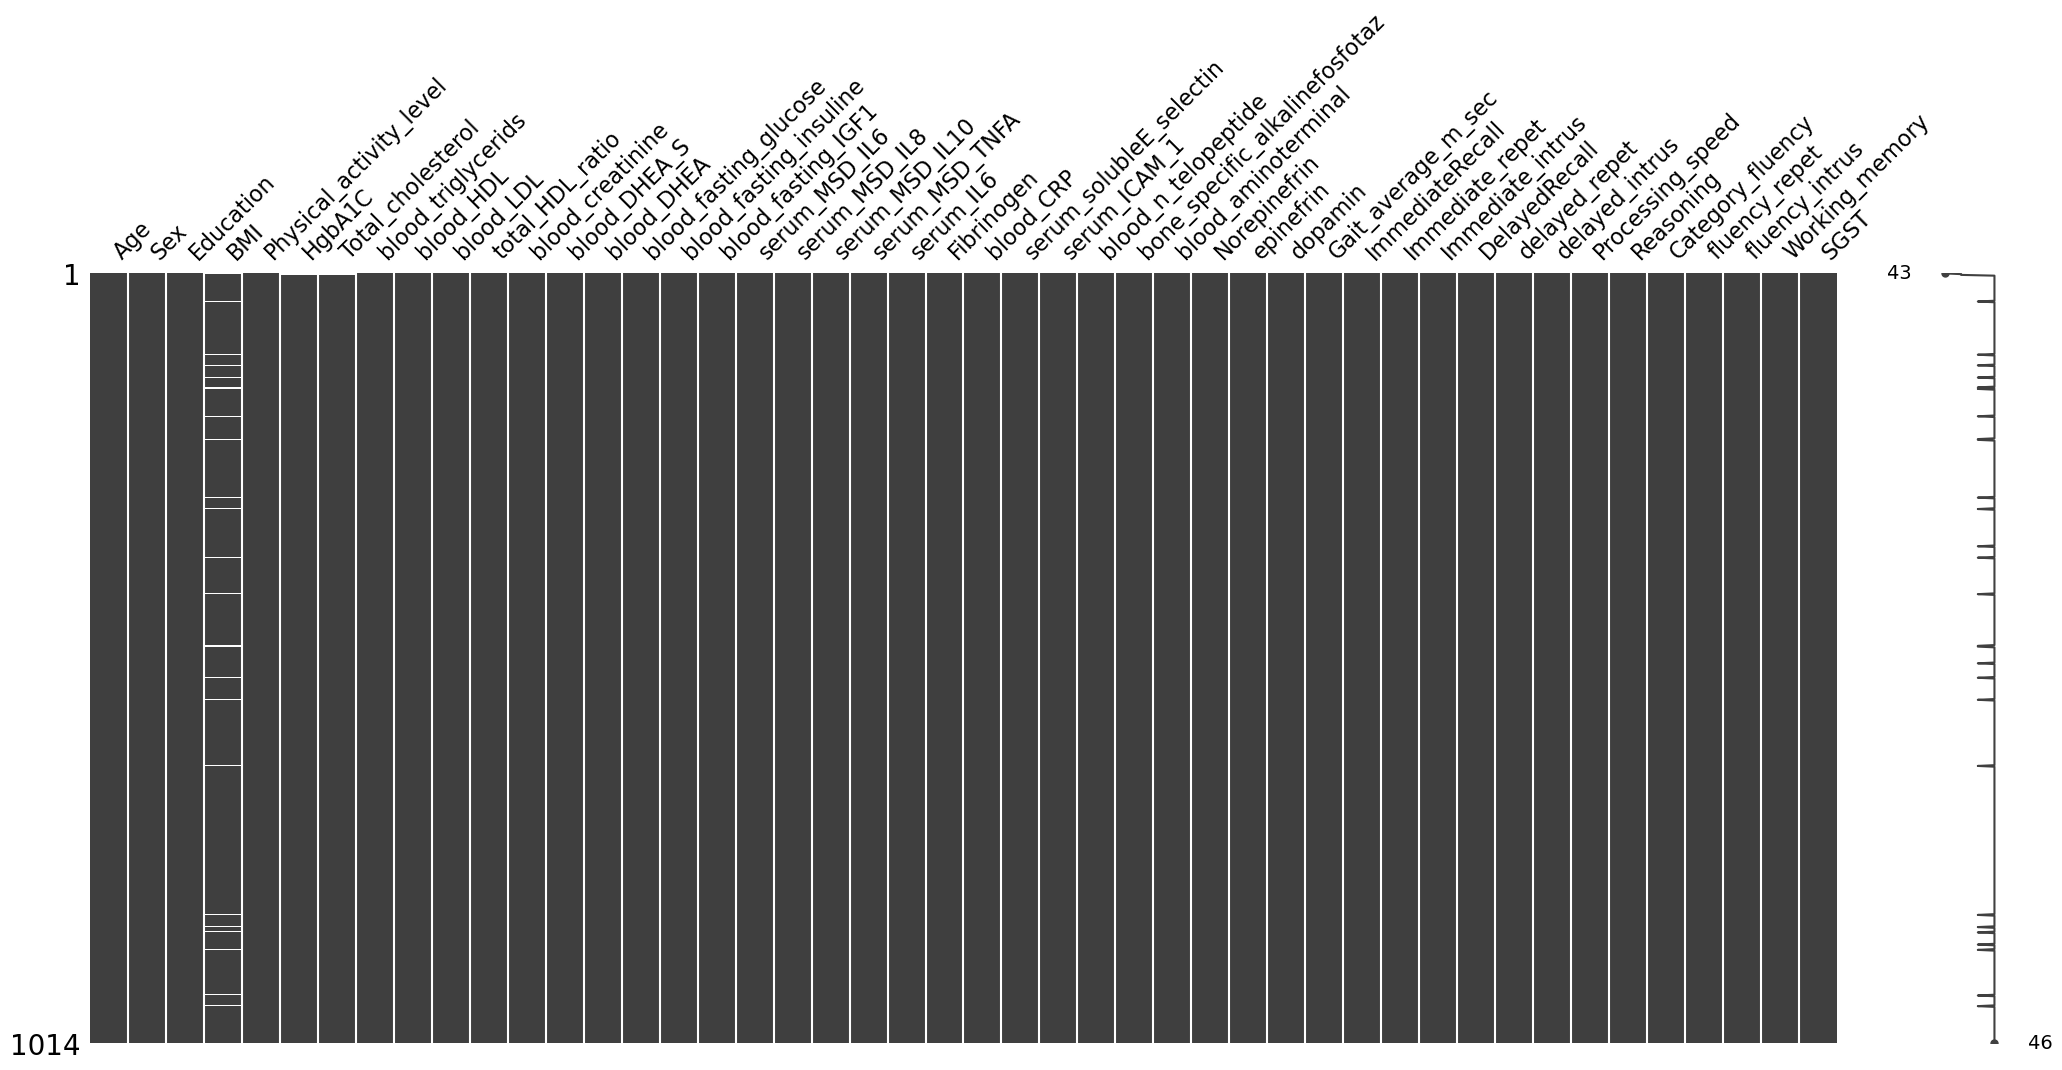

In [13]:
msno.matrix(train_df)

There are still some missing values on BMI. But we already dropped many records. We can impute them if required. Three-based algorithms handle missing data. I will try them first. 

## Descpriptive statistics

In [14]:
#numerical feature descriptive statistics
train_df.describe().T

count         mean          std        min  \
Age                             1014.0    46.402367    11.830150  25.000000   
Education                       1014.0     7.655819     3.717157   2.000000   
BMI                              986.0    29.294109    14.795500   9.440000   
Physical_activity_level         1014.0  1877.569576  7218.147183   0.000000   
HgbA1C                          1011.0     7.261776    10.886320   3.800000   
Total_cholesterol               1011.0   194.248269    85.859652  91.000000   
blood_triglycerids              1014.0   222.682446   936.219798  25.000000   
blood_HDL                       1014.0    64.707101    99.399480  19.000000   
blood_LDL                       1014.0   116.029586    98.737175  16.000000   
total_HDL_ratio                 1014.0     4.786509     9.950820   1.340000   
blood_creatinine                1014.0     1.741026     9.211850   0.500000   
blood_DHEA_S                    1014.0   117.253353   128.838218   0.900000   
blood_DHEA                      1014.0     7.078039    11.255792   0.400000   
blood_fasting_glucose           1014.0   113.446746   111.237385   5.000000   
blood_fasting_insuline          1014.0    27.318540   119.710749   1.000000   
blood_fasting_IGF1              1014.0   139.621302   116.523085  18.000000   
serum_MSD_IL6                   1014.0    13.053205   108.033643   0.110000   
serum_MSD_IL8                   1014.0    25.553964   107.352437   3.750000   
serum_MSD_IL10                  1014.0     1.550355    10.779533   0.050000   
serum_MSD_TNFA                  1014.0     3.372485    10.476573   0.310000   
serum_IL6                       1014.0     3.753635     9.917680   0.160000   
Fibrinogen                      1014.0   349.309665   113.404633  45.000000   
blood_CRP                       1014.0     4.024061    11.994229   0.034060   
serum_solubleE_selectin         1014.0    50.952022    96.934171   0.090000   
serum_ICAM_1                    1014.0   383.851252   965.219025  44.000000   
blood_n_telopeptide             1014.0    14.835187    10.765854   2.040000   
bone_specific_alkalinefosfotaz  1014.0    36.933393    96.650020   3.030000   
blood_aminoterminal             1014.0    65.547002    97.424591   7.250000   
Norepinefrin                    1014.0     3.160020    10.545010   0.230000   
epinefrin                       1014.0     1.789850    12.608430   0.009000   
dopamin                         1014.0    12.097791    12.212753   0.170000   
Gait_average_m_sec              1014.0     1.030100     0.599376   0.524934   
ImmediateRecall                 1014.0     7.177515     5.380493   1.000000   
Immediate_repet                 1014.0     0.515779     5.346000   0.000000   
Immediate_intrus                1014.0     0.768245     5.360502   0.000000   
DelayedRecall                   1014.0     7.418146    16.269652   0.000000   
delayed_repet                   1014.0     3.095661    16.866286   0.000000   
delayed_intrus                  1014.0     3.833333    16.779531   0.000000   
Processing_speed                1014.0    39.049310    10.952177  11.000000   
Reasoning                       1014.0     2.515779     1.520264   0.000000   
Category_fluency                1014.0    19.774162     5.852521   5.000000   
fluency_repet                   1014.0     0.313609     0.639496   0.000000   
fluency_intrus                  1014.0     0.047337     0.643694   0.000000   
Working_memory                  1014.0     5.112426     3.233766   0.000000   
SGST                            1014.0     3.457911    14.731106   0.676000   

                                      25%         50%          75%  \
Age                              37.00000   45.500000    55.000000   
Education                         5.00000    8.000000     9.000000   
BMI                              23.15350   26.083000    29.843250   
Physical_activity_level         180.00000  720.000000  1800.000000   
HgbA1C                            5.59780    5.8

There are many strange values on MAX column. I think these are not real measurements. They may be corrupted or missing records. Let's grab them and have a closer look.

In [15]:
contains_strange_values = train_df[train_df.isin([98, 99, 999, 998, 9999,9998]).any(axis=1)]

contains_strange_values.head(10).style.background_gradient('Reds')

Many records include 98, 99, 999, 998, 9999, 9998. I will change their value to nan. 

I did not touch any 98, 99, 999, 998, 9999, or 9998 values if it is a reasonable value within the features range. For example, I did not touch the 98 or 99 value on blood_fasting_glucose but changed the 999 to none.

In [16]:
train_df['BMI'] = train_df['BMI'].replace(99.000000, np.nan)
train_df['BMI'] = train_df['BMI'].replace(98.000000, np.nan)

train_df['Physical_activity_level'] = train_df['Physical_activity_level'].replace(99998.000000, np.nan)

train_df['Education'] = train_df['Education'].replace(97.000000, np.nan)


train_df['HgbA1C'] = train_df['HgbA1C'].replace(99.000000, np.nan)
train_df['HgbA1C'] = train_df['HgbA1C'].replace(98.000000, np.nan)

train_df['Total_cholesterol'] = train_df['Total_cholesterol'].replace(999.000000, np.nan)
train_df['Total_cholesterol'] = train_df['Total_cholesterol'].replace(998.000000, np.nan)

train_df['blood_triglycerids'] = train_df['blood_triglycerids'].replace(9999.000000, np.nan)
train_df['blood_triglycerids'] = train_df['blood_triglycerids'].replace(9998.000000, np.nan)

train_df['blood_HDL'] = train_df['blood_HDL'].replace(999.000000, np.nan)
train_df['blood_HDL'] = train_df['blood_HDL'].replace(998.000000, np.nan)

train_df['blood_LDL'] = train_df['blood_LDL'].replace(999.000000, np.nan)
train_df['blood_LDL'] = train_df['blood_LDL'].replace(998.000000, np.nan)

train_df['total_HDL_ratio'] = train_df['total_HDL_ratio'].replace(99.000000, np.nan)
train_df['total_HDL_ratio'] = train_df['total_HDL_ratio'].replace(98.000000, np.nan)

train_df['blood_creatinine'] = train_df['blood_creatinine'].replace(99.000000, np.nan)
train_df['blood_creatinine'] = train_df['blood_creatinine'].replace(98.000000, np.nan)

train_df['blood_DHEA_S'] = train_df['blood_DHEA_S'].replace(999.000000, np.nan)
train_df['blood_DHEA_S'] = train_df['blood_DHEA_S'].replace(998.000000, np.nan)

train_df['blood_DHEA'] = train_df['blood_DHEA'].replace(99.000000, np.nan)
train_df['blood_DHEA'] = train_df['blood_DHEA'].replace(98.000000, np.nan)

train_df['blood_fasting_glucose'] = train_df['blood_fasting_glucose'].replace(999.000000, np.nan)
train_df['blood_fasting_glucose'] = train_df['blood_fasting_glucose'].replace(998.000000, np.nan)

train_df['blood_fasting_insuline'] = train_df['blood_fasting_insuline'].replace(999.000000, np.nan)
train_df['blood_fasting_insuline'] = train_df['blood_fasting_insuline'].replace(998.000000, np.nan)

train_df['blood_fasting_IGF1'] = train_df['blood_fasting_IGF1'].replace(999.000000, np.nan)
train_df['blood_fasting_IGF1'] = train_df['blood_fasting_IGF1'].replace(998.000000, np.nan)

train_df['serum_MSD_IL6'] = train_df['serum_MSD_IL6'].replace(999.000000, np.nan)
train_df['serum_MSD_IL6'] = train_df['serum_MSD_IL6'].replace(998.000000, np.nan)

train_df['serum_MSD_IL8'] = train_df['serum_MSD_IL8'].replace(999.000000, np.nan)
train_df['serum_MSD_IL8'] = train_df['serum_MSD_IL8'].replace(998.000000, np.nan)

train_df['serum_MSD_IL10'] = train_df['serum_MSD_IL10'].replace(99.000000, np.nan)
train_df['serum_MSD_IL10'] = train_df['serum_MSD_IL10'].replace(98.000000, np.nan)

train_df['serum_MSD_TNFA'] = train_df['serum_MSD_TNFA'].replace(99.000000, np.nan)
train_df['serum_MSD_TNFA'] = train_df['serum_MSD_TNFA'].replace(98.000000, np.nan)

train_df['serum_IL6'] = train_df['serum_IL6'].replace(99.000000, np.nan)
train_df['serum_IL6'] = train_df['serum_IL6'].replace(98.000000, np.nan)

train_df['Fibrinogen'] = train_df['Fibrinogen'].replace(999.000000, np.nan)
train_df['Fibrinogen'] = train_df['Fibrinogen'].replace(998.000000, np.nan)

train_df['blood_CRP'] = train_df['blood_CRP'].replace(99.000000, np.nan)
train_df['blood_CRP'] = train_df['blood_CRP'].replace(98.000000, np.nan)

train_df['serum_solubleE_selectin'] = train_df['serum_solubleE_selectin'].replace(999.000000, np.nan)
train_df['serum_solubleE_selectin'] = train_df['serum_solubleE_selectin'].replace(998.000000, np.nan)

train_df['serum_ICAM_1'] = train_df['serum_ICAM_1'].replace(9999.000000, np.nan)
train_df['serum_ICAM_1'] = train_df['serum_ICAM_1'].replace(9998.000000, np.nan)

train_df['blood_n_telopeptide'] = train_df['blood_n_telopeptide'].replace(99.000000, np.nan)
train_df['blood_n_telopeptide'] = train_df['blood_n_telopeptide'].replace(98.000000, np.nan)

train_df['bone_specific_alkalinefosfotaz'] = train_df['bone_specific_alkalinefosfotaz'].replace(999.000000, np.nan)
train_df['bone_specific_alkalinefosfotaz'] = train_df['bone_specific_alkalinefosfotaz'].replace(998.000000, np.nan)

train_df['blood_aminoterminal'] = train_df['blood_aminoterminal'].replace(999.000000, np.nan)
train_df['blood_aminoterminal'] = train_df['blood_aminoterminal'].replace(998.000000, np.nan)

train_df['Norepinefrin'] = train_df['Norepinefrin'].replace(99.000000, np.nan)
train_df['Norepinefrin'] = train_df['Norepinefrin'].replace(98.000000, np.nan)

train_df['epinefrin'] = train_df['epinefrin'].replace(99.000000, np.nan)
train_df['epinefrin'] = train_df['epinefrin'].replace(98.000000, np.nan)

train_df['dopamin'] = train_df['dopamin'].replace(99.000000, np.nan)
train_df['dopamin'] = train_df['dopamin'].replace(98.000000, np.nan)

train_df['ImmediateRecall'] = train_df['ImmediateRecall'].replace(98.000000, np.nan)
train_df['ImmediateRecall'] = train_df['ImmediateRecall'].replace(99.000000, np.nan)

train_df['Immediate_repet'] = train_df['Immediate_repet'].replace(98.000000, np.nan)
train_df['Immediate_repet'] = train_df['Immediate_repet'].replace(99.000000, np.nan)

train_df['Immediate_intrus'] = train_df['Immediate_intrus'].replace(98.000000, np.nan)
train_df['Immediate_intrus'] = train_df['Immediate_intrus'].replace(99.000000, np.nan)

train_df['DelayedRecall'] = train_df['DelayedRecall'].replace(98.000000, np.nan)
train_df['DelayedRecall'] = train_df['DelayedRecall'].replace(99.000000, np.nan)

train_df['delayed_repet'] = train_df['delayed_repet'].replace(98.000000, np.nan)
train_df['delayed_repet'] = train_df['delayed_repet'].replace(99.000000, np.nan)

train_df['delayed_intrus'] = train_df['delayed_intrus'].replace(98.000000, np.nan)
train_df['delayed_intrus'] = train_df['delayed_intrus'].replace(99.000000, np.nan)

train_df['Working_memory'] = train_df['Working_memory'].replace(98.000000, np.nan)
train_df['Working_memory'] = train_df['Working_memory'].replace(99.000000, np.nan)

train_df['SGST'] = train_df['SGST'].replace(98.000000, np.nan)
train_df['SGST'] = train_df['SGST'].replace(99.000000, np.nan)



Let's count missing values again.. 

In [17]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

<Axes: >

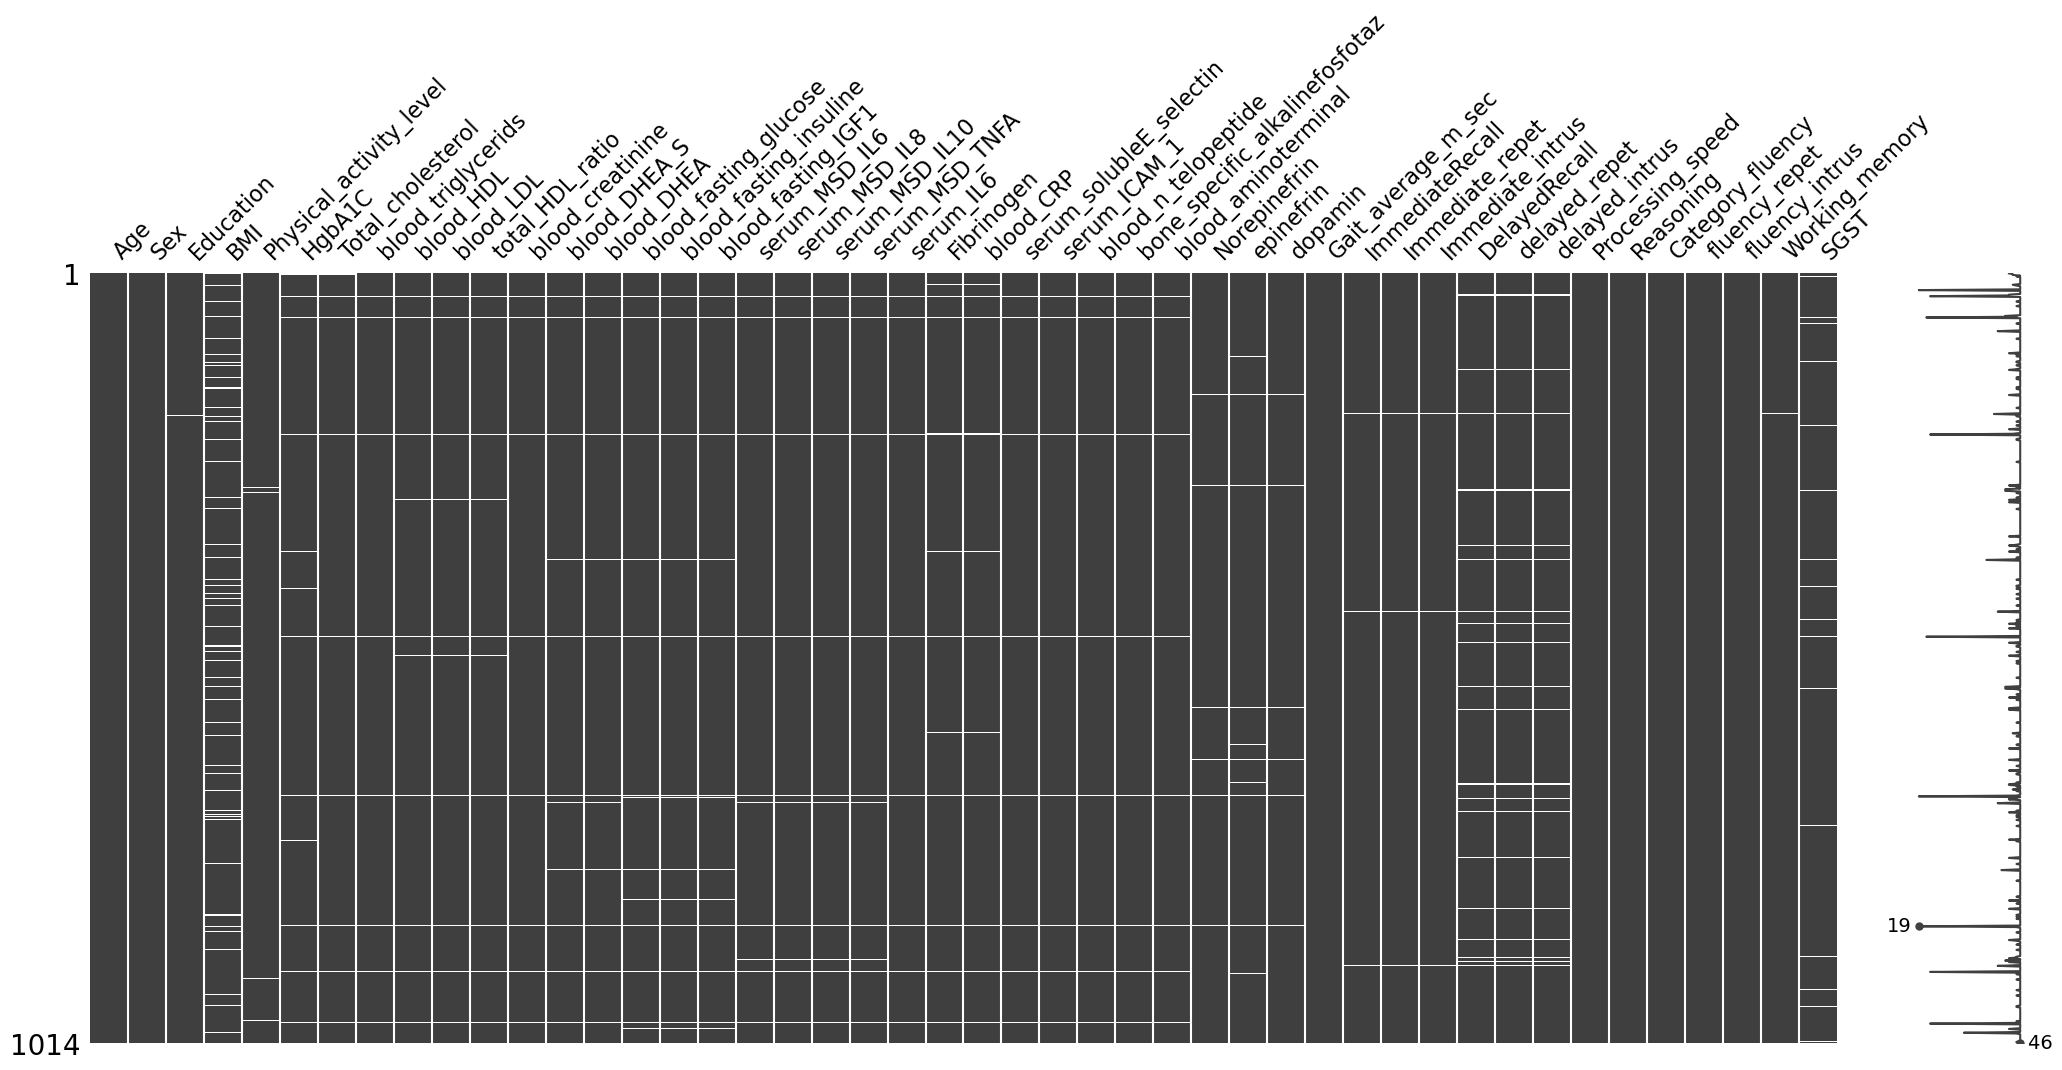

In [18]:
msno.matrix(train_df)

I will further drop the samples that have many missing values. (I dropped observations that contain more than 5 missing features)

In [19]:
train_df['number_of_NaNs'] = train_df.isna().sum(1)
rows_to_drop = train_df.loc[train_df['number_of_NaNs']>= 5]


In [20]:
indexes_drop = rows_to_drop.index
train_df = train_df.drop(indexes_drop, axis=0)


In [21]:
train_df = train_df.drop('number_of_NaNs', axis=1)


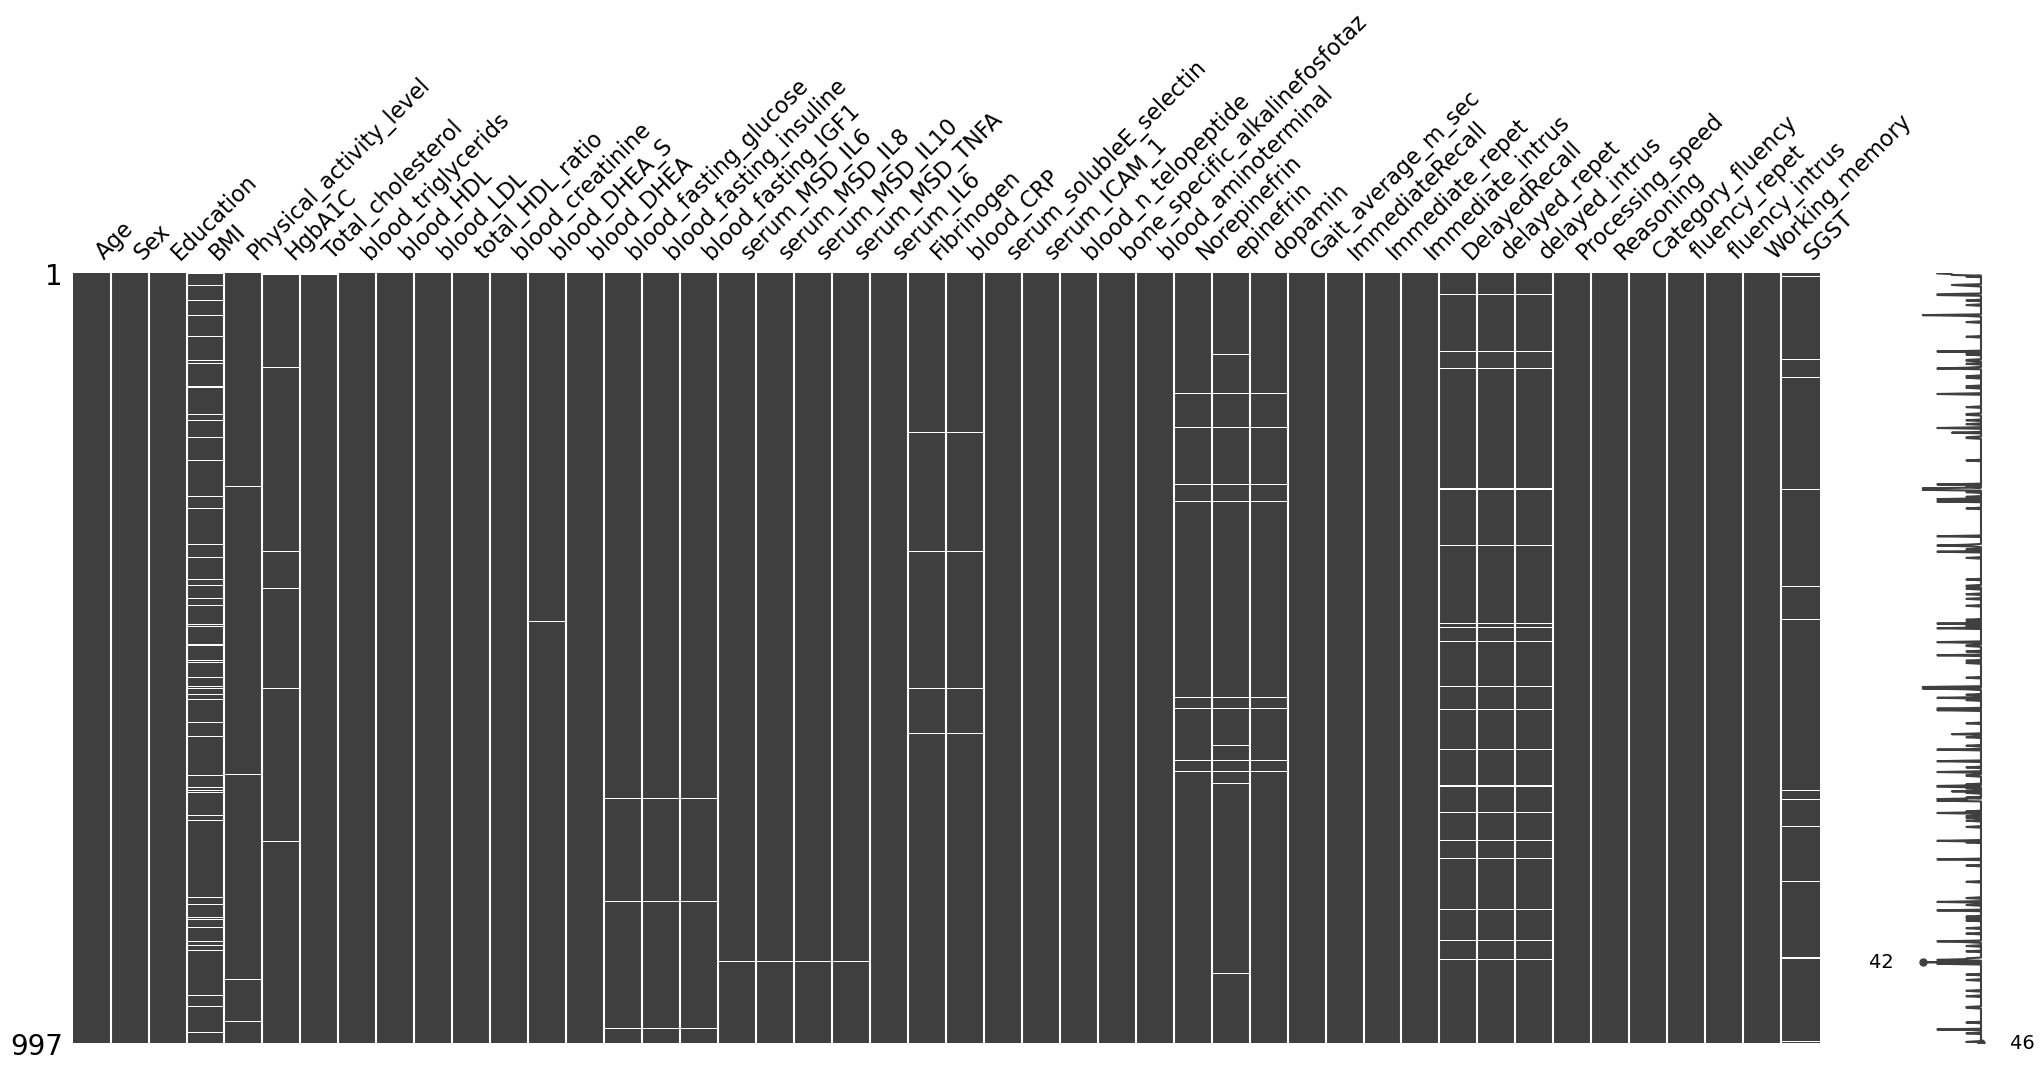

In [22]:
msno.matrix(train_df)
plt.show()

This is the final data that I will start analysis. 

We have 997 samples. There are still some missing values. But I will impute them if required.

Let's repeat descriptive statistics with clean data.

In [23]:
#numerical feature descriptive statistics
train_df.describe().T

count         mean          std        min  \
Age                             997.0    46.390171    11.841966  25.000000   
Education                       996.0     7.560241     2.440320   2.000000   
BMI                             931.0    26.456091     4.980032   9.440000   
Physical_activity_level         992.0  1384.921421  2078.279857   0.000000   
HgbA1C                          989.0     5.979447     0.884908   3.800000   
Total_cholesterol               994.0   186.934608    39.510203  91.000000   
blood_triglycerids              997.0   135.151454   141.675495  25.000000   
blood_HDL                       995.0    54.482412    17.471864  19.000000   
blood_LDL                       995.0   106.247236    34.737579  16.000000   
total_HDL_ratio                 995.0     3.752794     1.404701   1.340000   
blood_creatinine                997.0     0.870913     0.255455   0.500000   
blood_DHEA_S                    996.0   104.887450    75.841160   0.900000   
blood_DHEA                      997.0     5.883437     4.133735   0.400000   
blood_fasting_glucose           994.0   100.153924    24.694823   5.000000   
blood_fasting_insuline          994.0    12.738431    12.432294   1.000000   
blood_fasting_IGF1              994.0   126.671026    50.298099  18.000000   
serum_MSD_IL6                   996.0     1.251114     4.929747   0.110000   
serum_MSD_IL8                   996.0    13.918745    13.172348   3.750000   
serum_MSD_IL10                  996.0     0.386817     1.729297   0.050000   
serum_MSD_TNFA                  996.0     2.232118     0.845711   0.310000   
serum_IL6                       997.0     2.808722     2.834524   0.160000   
Fibrinogen                      992.0   340.108871    84.057932  45.000000   
blood_CRP                       992.0     2.687699     4.305169   0.034060   
serum_solubleE_selectin         997.0    41.532427    20.994271   0.090000   
serum_ICAM_1                    997.0   288.049930    99.958957  44.000000   
blood_n_telopeptide             997.0    13.996961     6.775862   2.040000   
bone_specific_alkalinefosfotaz  997.0    27.354203    10.704536   3.030000   
blood_aminoterminal             997.0    56.218415    28.423415   7.250000   
Norepinefrin                    989.0     2.014459     1.563497   0.230000   
epinefrin                       984.0     0.144564     0.118117   0.009000   
dopamin                         989.0    11.065784     7.799927   0.170000   
Gait_average_m_sec              997.0     1.013770     0.525332   0.524934   
ImmediateRecall                 997.0     6.909729     2.113229   1.000000   
Immediate_repet                 997.0     0.221665     0.587702   0.000000   
Immediate_intrus                997.0     0.481444     0.812124   0.000000   
DelayedRecall                   971.0     4.561277     2.426466   0.000000   
delayed_repet                   971.0     0.104016     0.396498   0.000000   
delayed_intrus                  971.0     0.870237     1.304097   0.000000   
Processing_speed                997.0    39.073220    10.984822  11.000000   
Reasoning                       997.0     2.517553     1.512645   0.000000   
Category_fluency                997.0    19.773320     5.832223   5.000000   
fluency_repet                   997.0     0.318957     0.643606   0.000000   
fluency_intrus                  997.0     0.048144     0.649134   0.000000   
Working_memory                  997.0     5.026078     1.393949   0.000000   
SGST                            976.0     1.165359     0.333665   0.676000   

                                      25%         50%          75%  \
Age                              37.00000   45.000000    55.000000   
Education                         5.00000    8.000000     9.000000   
BMI                              22.86100   25.825000    29.200000   
Physical_activity_level         173.25000  720.000000  1758.000000   
HgbA1C                            5.59780    5.800000     6.115400   
Total_cholesterol      

A clear observation is that there are some strong outliers on target varaible Gait_average_m_sec. Let's make a visualization.

<Axes: xlabel='Gait_average_m_sec', ylabel='Count'>

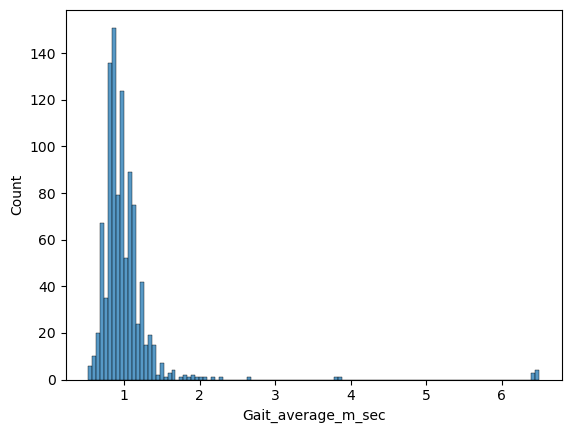

In [24]:
 sns.histplot(x='Gait_average_m_sec',  data=train_df )

There are outliers at the higher end. Let's look at those samples to see if they are legitimate samples.

In [25]:
gait_avarage_outliers = train_df.loc[train_df['Gait_average_m_sec']>= 2]

gait_avarage_outliers.style.background_gradient('Reds')

Some of these samples contains largest values on a specific columns. I noted them below. 

* 14283: reasoning 5.000000
* 15944: dopamin 45, blood_CRP 61.700000
* 16705: SGST 6.322000
* 17400: Working memory 8
* 17647: Working memory 8, dopamin 45 
* 18679: reasoning 5.000000

Here, I will drop these samples. Note that this is an important decision since this decision will affect machine learning models' performance significantly(This is specifically true for regression modeling. For classification, we will map values to 0 and 1. This mapping can reduce the significance of outliers). If these are valid samples, we may need to reconsider.

In [26]:
indexes_drop = gait_avarage_outliers.index
train_df = train_df.drop(indexes_drop, axis=0)

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 10002 to 19193
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Age                             983 non-null    int64   
 1   Sex                             983 non-null    category
 2   Education                       982 non-null    float64 
 3   BMI                             921 non-null    float64 
 4   Physical_activity_level         978 non-null    float64 
 5   HgbA1C                          976 non-null    float64 
 6   Total_cholesterol               980 non-null    float64 
 7   blood_triglycerids              983 non-null    float64 
 8   blood_HDL                       981 non-null    float64 
 9   blood_LDL                       981 non-null    float64 
 10  total_HDL_ratio                 981 non-null    float64 
 11  blood_creatinine                983 non-null    float64 
 12  blood_DHEA_S    

Let's calculate descriptive stats one more time.

In [28]:
#numerical feature descriptive statistics
train_df.describe().T

count         mean          std        min  \
Age                             983.0    46.215666    11.737379  25.000000   
Education                       982.0     7.551935     2.442165   2.000000   
BMI                             921.0    26.446593     4.971295   9.440000   
Physical_activity_level         978.0  1401.586452  2088.094825   0.000000   
HgbA1C                          976.0     5.977528     0.889817   3.800000   
Total_cholesterol               980.0   186.910204    39.677094  91.000000   
blood_triglycerids              983.0   135.344863   142.371141  25.000000   
blood_HDL                       981.0    54.363914    17.439607  19.000000   
blood_LDL                       981.0   106.316004    34.819096  16.000000   
total_HDL_ratio                 981.0     3.759154     1.405357   1.340000   
blood_creatinine                983.0     0.871414     0.255861   0.500000   
blood_DHEA_S                    982.0   105.634318    76.017372   0.900000   
blood_DHEA                      983.0     5.910334     4.146560   0.400000   
blood_fasting_glucose           980.0   100.176531    24.828121   5.000000   
blood_fasting_insuline          980.0    12.761224    12.437633   1.000000   
blood_fasting_IGF1              980.0   126.639796    50.203385  18.000000   
serum_MSD_IL6                   982.0     1.236935     4.958270   0.110000   
serum_MSD_IL8                   982.0    13.890479    13.251436   3.750000   
serum_MSD_IL10                  982.0     0.387862     1.741521   0.050000   
serum_MSD_TNFA                  982.0     2.227749     0.838779   0.310000   
serum_IL6                       983.0     2.777148     2.794114   0.160000   
Fibrinogen                      979.0   339.508682    83.777304  45.000000   
blood_CRP                       979.0     2.599589     3.808412   0.034060   
serum_solubleE_selectin         983.0    41.352838    20.893557   0.090000   
serum_ICAM_1                    983.0   287.415331   100.062098  44.000000   
blood_n_telopeptide             983.0    13.957833     6.700115   2.040000   
bone_specific_alkalinefosfotaz  983.0    27.287152    10.593936   3.030000   
blood_aminoterminal             983.0    56.227009    28.368660   7.250000   
Norepinefrin                    976.0     2.011527     1.555734   0.230000   
epinefrin                       971.0     0.144738     0.118575   0.009000   
dopamin                         976.0    11.012971     7.620362   0.170000   
Gait_average_m_sec              983.0     0.962992     0.203536   0.524934   
ImmediateRecall                 983.0     6.923703     2.100644   1.000000   
Immediate_repet                 983.0     0.219736     0.585411   0.000000   
Immediate_intrus                983.0     0.481180     0.811954   0.000000   
DelayedRecall                   958.0     4.563674     2.398104   0.000000   
delayed_repet                   958.0     0.105428     0.398995   0.000000   
delayed_intrus                  958.0     0.862213     1.301800   0.000000   
Processing_speed                983.0    39.166836    10.980108  11.000000   
Reasoning                       983.0     2.525941     1.510684   0.000000   
Category_fluency                983.0    19.805697     5.791690   5.000000   
fluency_repet                   983.0     0.318413     0.644052   0.000000   
fluency_intrus                  983.0     0.048830     0.653719   0.000000   
Working_memory                  983.0     5.031536     1.389524   0.000000   
SGST                            963.0     1.159607     0.290020   0.676000   

                                      25%         50%          75%  \
Age                              37.00000   45.000000    55.000000   
Education                         5.00000    8.000000     9.000000   
BMI                              22.85900   25.825000    29.170000   
Physical_activity_level         180.00000  720.000000  1797.000000   
HgbA1C                            5.59780    5.800000     6.115400   
Total_cholesterol      

I will discretize the target (Gait_average_m_sec) as below 0.8 and above 0.8. 
* Class 1 indicates below-0.8
* Class 0 indicated above-0.8

0.8 is considered as a critical treshold since it is a cut off for fall risk.

In [29]:
# Gait_average_m_sec is mapped to 0 and 1 / 1 indicates below 0.8 samples
train_df['Gait_average_low'] = (train_df['Gait_average_m_sec'] < 0.8 ).astype(int)

In [30]:
train_df[['Gait_average_m_sec','Gait_average_low']]

Gait_average_m_sec  Gait_average_low
ID                                         
10002            0.984252                 0
10005            0.984252                 0
10019            0.787402                 1
10040            0.853018                 0
10047            0.787402                 1
...                   ...               ...
19157            0.984252                 0
19175            0.820210                 0
19181            0.984252                 0
19190            0.656168                 1
19193            0.853018                 0

[983 rows x 2 columns]

In [31]:
#drop original column
train_df =  train_df.drop(['Gait_average_m_sec'], axis=1)

Let's observe target distribution

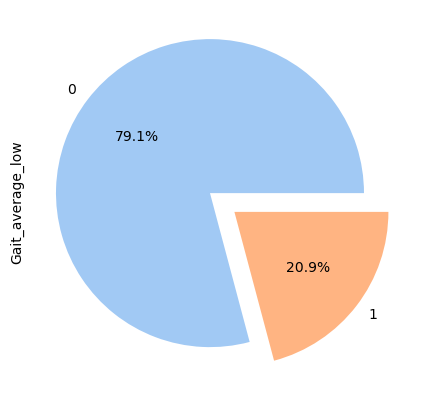

In [32]:
#Target Distribution
plt.figure(figsize=(5,5))
palette_color = sns.color_palette('pastel')
explode = [0.1, 0.1]
train_df.groupby('Gait_average_low')['Gait_average_low'].count().plot.pie(colors=palette_color,explode=explode, autopct="%1.1f%%");

79.1% of samples are above 0.8. 20.8% of samples are below 0.8. 

Target variable distribution is quite imbalanced. At the modeling stage, the Synthetic Minority Over-sampling Technique (SMOTE) and class_weight adjustment are used to deal with this imbalance distribution.

Although accuracy is a default metric for most classification problems, it's generally misleading for imbalanced data sets. That is why the F1 score is used as an optimization metric. 

F1 score is defined as the harmonic mean of precision and recall.

![ ]( https://www.researchgate.net/publication/367393140/figure/fig4/AS:11431281114710300@1674648981676/Confusion-matrix-Precision-Recall-Accuracy-and-F1-score.jpg 

Note that a dummy classifier that always says gait_avarage is above 0.8 will have a 79.1% accuracy. Although the best-found model did not beat the dummy accuracy, it has better discriminative power on class 1. Judgment of models' usefulness is left to you.

## Grouping features for preprocessing purposes

Different data types will require different preprocessing techniques. Here, I will group features for bookkeeping and preprocessing purposes.

In [33]:
train_df.nunique().sort_values()

Gait_average_low                    2
Sex                                 2
fluency_repet                       4
fluency_intrus                      5
delayed_repet                       5
Immediate_repet                     5
Reasoning                           6
Immediate_intrus                    7
Working_memory                      8
delayed_intrus                     10
Education                          11
ImmediateRecall                    13
DelayedRecall                      15
blood_creatinine                   18
Category_fluency                   35
Age                                49
blood_fasting_insuline             58
Processing_speed                   63
epinefrin                          77
blood_HDL                          86
blood_fasting_glucose              99
serum_MSD_IL10                    101
HgbA1C                            107
Norepinefrin                      134
blood_LDL                         165
Total_cholesterol                 185
blood_fastin

In [34]:
# Just bookkeeping
feature_list = [feature for feature in train_df.columns if not feature  == "Gait_average_low"]
categorical_features = [feature for feature in train_df.columns if 
                        train_df[feature].dtype == "category"] 
numerical_features = [feature for feature in train_df.columns if 
                      feature not in categorical_features + ['Gait_average_low']]

discrete_features = ['fluency_repet', 'fluency_intrus','Immediate_repet','delayed_repet','Reasoning','Immediate_intrus','Working_memory']

continuous_features = list(set(numerical_features) - set(discrete_features))

assert feature_list.sort() == (categorical_features + numerical_features).sort()
assert numerical_features.sort() == (continuous_features + discrete_features).sort()


<a id = "4"></a><br>
# Exploratory Data Analysis

Let's observe features with respect to target.

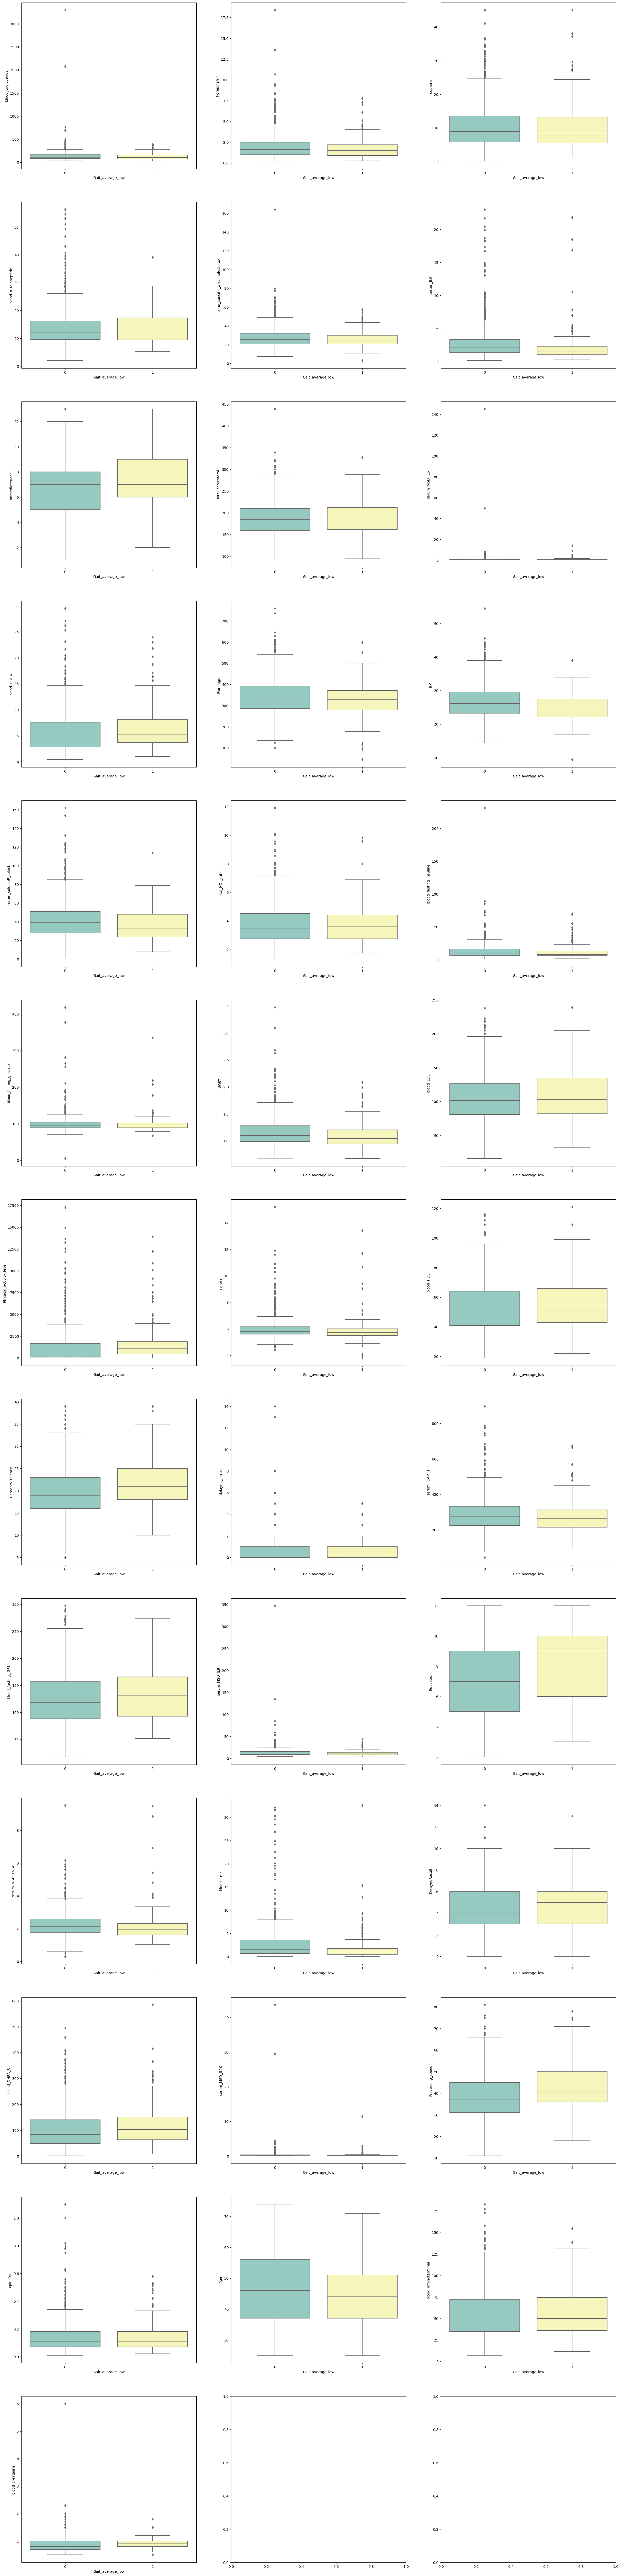

In [35]:
fig, ax = plt.subplots(13, 3, figsize=(30, 130))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Gait_average_low', y=var, data=train_df, ax=subplot, palette='Set3')

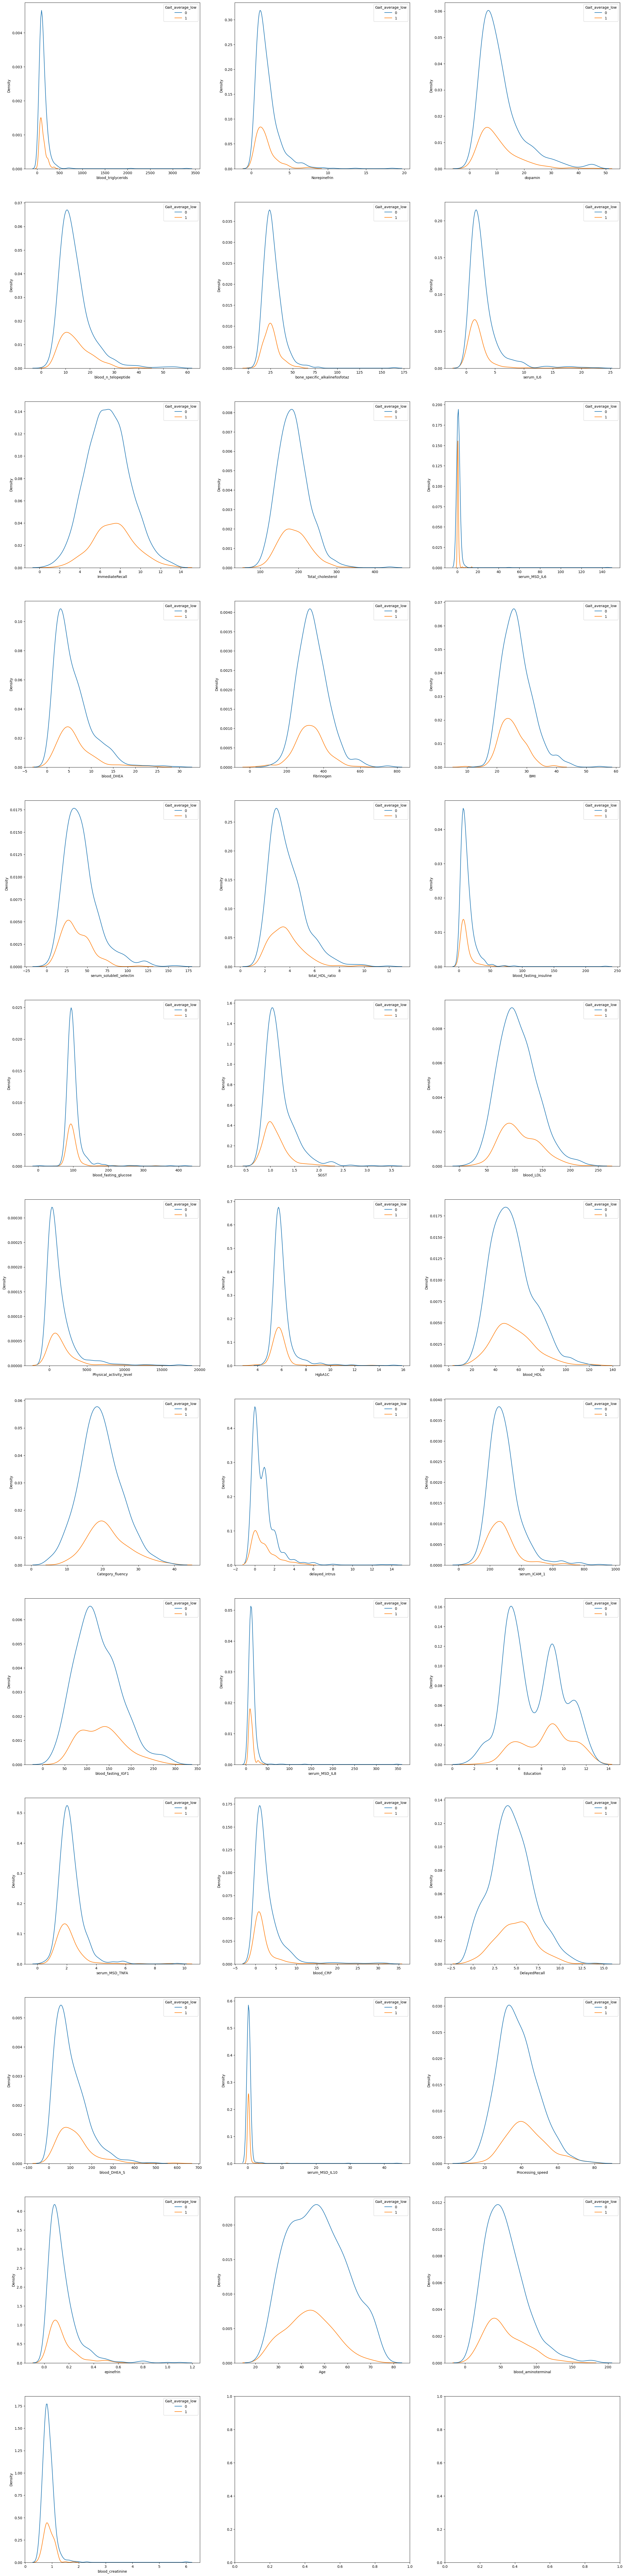

In [36]:
fig, ax = plt.subplots(13, 3, figsize=(30, 130))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.kdeplot(x=var,  data=train_df, ax=subplot, hue='Gait_average_low' )

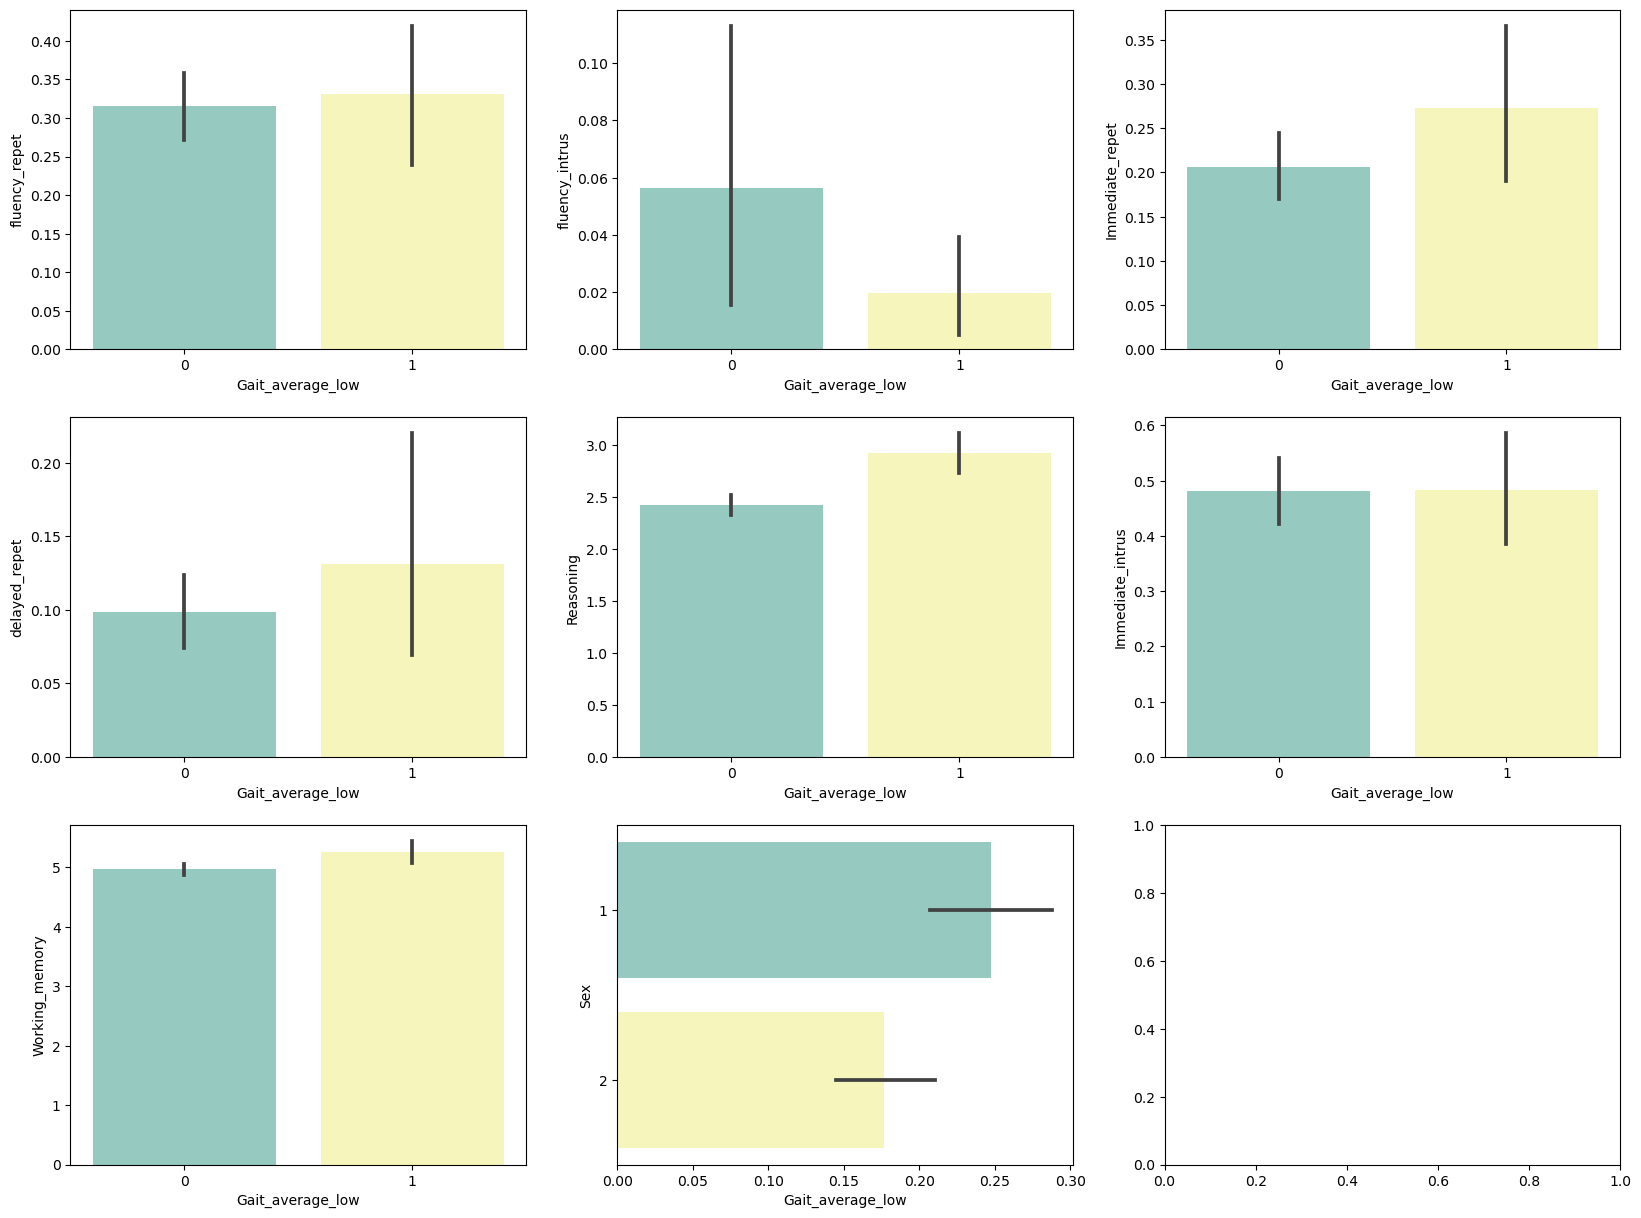

In [37]:
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
for var, subplot in zip(discrete_features + categorical_features, ax.flatten()):
    sns.barplot(x='Gait_average_low', y= var, data=train_df, ax=subplot, palette='Set3')

Let's look at the relationship between features and the target more quantitatively...

Correlation is not a good measure for classification problems. 

(It is good at measuring linear relations between continuous variables, but our target is discrete)

Let's check mutual information, which measures this kind of relationship well.

In [38]:
y = train_df.Gait_average_low

In [39]:
# determine the mutual information for numerical features
#You need to fill missing values to get results from mutual_info_classif function
mutual_df = train_df[numerical_features ]

mutual_info = mutual_info_classif(mutual_df.fillna(mutual_df.mean()), y, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")


In [40]:
#train_df.to_csv('unbalanced.csv')

We have weak relations... A sign that we will not get a perfect model. But I will try my best..

Dropping noninformative features mostly helps to avoid overfitting. I will drop columns that have low mutual information scores. (I also tried without dropping. It didn't perform better.)

In [41]:
no_info_cols = mutual_info[mutual_info['Numerical_Feature_MI'] < 0.00001].index.values.tolist()
no_info_cols

['Fibrinogen',
 'serum_MSD_IL8',
 'serum_MSD_IL6',
 'serum_MSD_IL10',
 'serum_ICAM_1',
 'epinefrin',
 'Total_cholesterol',
 'HgbA1C',
 'blood_DHEA',
 'bone_specific_alkalinefosfotaz',
 'Immediate_intrus',
 'Immediate_repet',
 'blood_fasting_IGF1',
 'blood_creatinine',
 'Norepinefrin',
 'blood_LDL',
 'Reasoning',
 'blood_DHEA_S',
 'blood_aminoterminal']

In [42]:
#Dropping no info columns generally helps. 
train_df = train_df.drop(no_info_cols, axis=1)

Mutual information also work with preprocessed categorical variables.

In [43]:
mutual_df_categorical = train_df[categorical_features]
#categorical features must be encoded to get mutual information
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_info = mutual_info_classif(mutual_df_categorical, y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")


Sex will not be a discriminative feature...

<a id = "4"></a><br>
# Modeling and hyperparameter tuning

%80 of the data is used for training, and 10-fold cross-validation is performed. %20 percent of the data is reserved as a test set for final model evaluation. 

Target variable distribution is quite imbalanced. At the modeling stage, the Synthetic Minority Over-sampling Technique (SMOTE) and class_weight adjustment are used to deal with this imbalance distribution.

Although accuracy is a default metric for most classification problems, it's generally misleading for imbalanced data sets. That is why the F1 score is used as an optimization metric. 

F1 score is defined as the harmonic mean of precision and recall.

![ ]( https://www.researchgate.net/publication/367393140/figure/fig4/AS:11431281114710300@1674648981676/Confusion-matrix-Precision-Recall-Accuracy-and-F1-score.jpg)

In [44]:
#seperate target
y = train_df['Gait_average_low']
train_df = train_df.drop(['Gait_average_low'], axis=1)
train_df = pd.get_dummies(train_df)


In [45]:
#create train-test split. 
X_train, X_test, y_train, y_test = train_test_split(train_df, y, 
                                                    test_size=0.2,
                                                    random_state=random_state,
                                                    shuffle=True,
                                                    stratify=y)


print(X_train.shape, X_test.shape)

(786, 27) (197, 27)


Tree-based boosting algorithms generally perform well with tabular data sets. I tried LightGBM, XGBoost, HistogramGradientBoosting, and Catboost algorithms. 

I also used the Optuna package for hyperparameter tuning. It uses Bayesian optimization to optimize the hyperparameters. You can check cross-validation results from Optuna outputs. In the end, I also compared the performances of different models on the test set. I also reported the importance of features for the best-performing model.

In [46]:
#SMOTE for oversampling of minority class(class 1)
sm = SMOTE(random_state=random_state)

#for imputing missing values
imputer = SimpleImputer(strategy='mean')


<a id = "5"></a><br>
# Try lightgbm

<a id = "5"></a><br>
# Lightgbm with SMOTE

In [47]:
#lightgbm



def objective(trial):


    n_estimators = trial.suggest_int("n_estimators", 30, 500)
    max_depth = trial.suggest_int("max_depth", 2, 12)
    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 20)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)        
    max_bin = trial.suggest_int("max_bin", 100, 350, step=10)
    feature_fraction = trial.suggest_float("feature_fraction", 0.1, 1.0)
    #scale_pos_weight = trial.suggest_float("scale_pos_weight", 0.1, 100.0,log=True )
    #eval_metric = 'logloss'
    #objective = 'binary:logistic' 



    
    

    lgbm_classifier = LGBMClassifier(n_estimators = n_estimators,max_depth=max_depth,learning_rate=learning_rate,
                                     min_data_in_leaf=min_data_in_leaf, subsample=subsample,max_bin=max_bin,
                                     feature_fraction=feature_fraction, random_state =random_state,
                                     verbose=-1)
   
    # -- Make a pipeline
    lgbm_pipeline = imbpipeline([
    
    ('imputer', imputer),
     ('smote', sm),
    ("lgbm_classifier", lgbm_classifier)
])



    
    ss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
    score = cross_val_score(lgbm_pipeline, X_train, y_train, scoring= make_scorer(f1_score),   cv=ss)
    score = score.mean()
    return score


sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)
    

[I 2024-01-01 22:46:00,622] A new study created in memory with name: no-name-3d0def1e-c99a-4e71-9137-aba928badb4b
  File "C:\Users\Public\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Public\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Public\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Public\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
[I 2024-01-01 22:46:03,377] Trial 0 finished with value: 0.05527544351073763 and parameters: {'n_estimators': 206, 'max_depth': 12, 'learning_rate': 0.015702970884055395, 'min_data_in_le

[I 2024-01-01 22:46:59,895] Trial 23 finished with value: 0.40009480799674363 and parameters: {'n_estimators': 272, 'max_depth': 4, 'learning_rate': 0.0026813746241675577, 'min_data_in_leaf': 4, 'subsample': 0.15957168915232764, 'max_bin': 230, 'feature_fraction': 0.9431016048382258}. Best is trial 14 with value: 0.44751718081472375.
[I 2024-01-01 22:47:01,957] Trial 24 finished with value: 0.39320335710041593 and parameters: {'n_estimators': 367, 'max_depth': 3, 'learning_rate': 0.007478351813817523, 'min_data_in_leaf': 16, 'subsample': 0.1982012685806998, 'max_bin': 330, 'feature_fraction': 0.9923192683237805}. Best is trial 14 with value: 0.44751718081472375.
[I 2024-01-01 22:47:03,705] Trial 25 finished with value: 0.4165734831928797 and parameters: {'n_estimators': 394, 'max_depth': 2, 'learning_rate': 0.0018559721571896309, 'min_data_in_leaf': 9, 'subsample': 0.33143311984419394, 'max_bin': 260, 'feature_fraction': 0.8792688950314681}. Best is trial 14 with value: 0.4475171808147

[I 2024-01-01 22:47:54,717] Trial 48 finished with value: 0.4214417704590705 and parameters: {'n_estimators': 199, 'max_depth': 2, 'learning_rate': 0.006855350706377088, 'min_data_in_leaf': 5, 'subsample': 0.29044018721773057, 'max_bin': 290, 'feature_fraction': 0.8440398492586353}. Best is trial 30 with value: 0.46519902027604204.
[I 2024-01-01 22:47:56,349] Trial 49 finished with value: 0.429175947359309 and parameters: {'n_estimators': 349, 'max_depth': 2, 'learning_rate': 0.013556550051246504, 'min_data_in_leaf': 8, 'subsample': 0.13562543963874876, 'max_bin': 140, 'feature_fraction': 0.9572179024769656}. Best is trial 30 with value: 0.46519902027604204.
[I 2024-01-01 22:47:59,776] Trial 50 finished with value: 0.3047887306572611 and parameters: {'n_estimators': 240, 'max_depth': 9, 'learning_rate': 0.004416923188939249, 'min_data_in_leaf': 11, 'subsample': 0.18338390154118628, 'max_bin': 350, 'feature_fraction': 0.9216980565587468}. Best is trial 30 with value: 0.46519902027604204

[I 2024-01-01 22:48:43,752] Trial 73 finished with value: 0.44365821862389365 and parameters: {'n_estimators': 321, 'max_depth': 2, 'learning_rate': 0.011655556522810813, 'min_data_in_leaf': 8, 'subsample': 0.2526793757953129, 'max_bin': 270, 'feature_fraction': 0.974598143842875}. Best is trial 30 with value: 0.46519902027604204.
[I 2024-01-01 22:48:45,581] Trial 74 finished with value: 0.38500210179527067 and parameters: {'n_estimators': 460, 'max_depth': 2, 'learning_rate': 0.01415477014456872, 'min_data_in_leaf': 8, 'subsample': 0.2680158700765996, 'max_bin': 270, 'feature_fraction': 0.9432069697174341}. Best is trial 30 with value: 0.46519902027604204.
[I 2024-01-01 22:48:47,903] Trial 75 finished with value: 0.3156583286721349 and parameters: {'n_estimators': 495, 'max_depth': 3, 'learning_rate': 0.010789581671001549, 'min_data_in_leaf': 6, 'subsample': 0.24208177722993457, 'max_bin': 310, 'feature_fraction': 0.9723124152423333}. Best is trial 30 with value: 0.46519902027604204.


[I 2024-01-01 22:49:31,079] Trial 98 finished with value: 0.4521365460030415 and parameters: {'n_estimators': 454, 'max_depth': 2, 'learning_rate': 0.005513402545176007, 'min_data_in_leaf': 17, 'subsample': 0.1372008510327077, 'max_bin': 240, 'feature_fraction': 0.8632617467724999}. Best is trial 30 with value: 0.46519902027604204.
[I 2024-01-01 22:49:32,946] Trial 99 finished with value: 0.45935801041064195 and parameters: {'n_estimators': 496, 'max_depth': 2, 'learning_rate': 0.005857022464266429, 'min_data_in_leaf': 17, 'subsample': 0.13488049190517445, 'max_bin': 240, 'feature_fraction': 0.8618116874703965}. Best is trial 30 with value: 0.46519902027604204.


<a id = "5"></a><br>
## Lightgbm with Class Weight Adjusment

In [48]:
#lightgbm



def objective(trial):


    n_estimators = trial.suggest_int("n_estimators", 30, 500)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 20)
    subsample = trial.suggest_float("subsample", 0.2, 0.7)        
    max_bin = trial.suggest_int("max_bin", 100, 350, step=10)
    feature_fraction = trial.suggest_float("feature_fraction", 0.1, 0.5)
    scale_pos_weight = trial.suggest_float("scale_pos_weight", 0.1, 10,log=True )
    #eval_metric = 'logloss'
    #objective = 'binary:logistic' 



    
    

    lgbm_classifier = LGBMClassifier(n_estimators = n_estimators,max_depth=max_depth,learning_rate=learning_rate,
                                     min_data_in_leaf=min_data_in_leaf, subsample=subsample,max_bin=max_bin,
                                     feature_fraction=feature_fraction, random_state =random_state,
                                     scale_pos_weight=scale_pos_weight, verbose=-1)
   
    # -- Make a pipeline
    lgbm_pipeline = imbpipeline([
    
    ('imputer', imputer),
     #('smote', sm),
    ("lgbm_classifier", lgbm_classifier)
])



    
    ss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
    score = cross_val_score(lgbm_pipeline, X_train, y_train, scoring= make_scorer(f1_score),   cv=ss)
    score = score.mean()
    return score


sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)
    

[I 2024-01-01 22:49:32,978] A new study created in memory with name: no-name-210b9e6e-29f0-4e26-b895-36bdce238a35
[I 2024-01-01 22:49:34,162] Trial 0 finished with value: 0.3519396182038497 and parameters: {'n_estimators': 206, 'max_depth': 15, 'learning_rate': 0.015702970884055395, 'min_data_in_leaf': 12, 'subsample': 0.27800932022121827, 'max_bin': 140, 'feature_fraction': 0.12323344486727979, 'scale_pos_weight': 5.3994844097874335}. Best is trial 0 with value: 0.3519396182038497.
[I 2024-01-01 22:49:35,606] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 313, 'max_depth': 11, 'learning_rate': 0.00011527987128232407, 'min_data_in_leaf': 20, 'subsample': 0.6162213204002108, 'max_bin': 150, 'feature_fraction': 0.17272998688284025, 'scale_pos_weight': 0.2327067708383781}. Best is trial 0 with value: 0.3519396182038497.
[I 2024-01-01 22:49:36,713] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 173, 'max_depth': 9, 'learning_rate': 0.001976218934028007

[I 2024-01-01 22:50:06,024] Trial 22 finished with value: 0.31880687536416125 and parameters: {'n_estimators': 349, 'max_depth': 4, 'learning_rate': 0.04333111884076761, 'min_data_in_leaf': 4, 'subsample': 0.3309493821585888, 'max_bin': 240, 'feature_fraction': 0.19789097600661654, 'scale_pos_weight': 5.875391082210614}. Best is trial 16 with value: 0.40799686741674845.
[I 2024-01-01 22:50:06,596] Trial 23 finished with value: 0.42908807946274496 and parameters: {'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.019429295415477797, 'min_data_in_leaf': 9, 'subsample': 0.25696276965544956, 'max_bin': 290, 'feature_fraction': 0.15708303455139427, 'scale_pos_weight': 5.6552988958878165}. Best is trial 23 with value: 0.42908807946274496.
[I 2024-01-01 22:50:07,269] Trial 24 finished with value: 0.3671980204199946 and parameters: {'n_estimators': 265, 'max_depth': 3, 'learning_rate': 0.0527256423125985, 'min_data_in_leaf': 9, 'subsample': 0.25944746590724715, 'max_bin': 290, 'feature_f

[I 2024-01-01 22:50:21,723] Trial 44 finished with value: 0.4128158373101396 and parameters: {'n_estimators': 163, 'max_depth': 4, 'learning_rate': 0.03993300194474292, 'min_data_in_leaf': 8, 'subsample': 0.39753783925138275, 'max_bin': 340, 'feature_fraction': 0.13763200244038076, 'scale_pos_weight': 7.262683974131013}. Best is trial 23 with value: 0.42908807946274496.
[I 2024-01-01 22:50:22,327] Trial 45 finished with value: 0.37880210135185943 and parameters: {'n_estimators': 160, 'max_depth': 4, 'learning_rate': 0.04001260468839705, 'min_data_in_leaf': 8, 'subsample': 0.3530544682297201, 'max_bin': 340, 'feature_fraction': 0.12638266420376545, 'scale_pos_weight': 7.930908580511486}. Best is trial 23 with value: 0.42908807946274496.
[I 2024-01-01 22:50:22,892] Trial 46 finished with value: 0.11001031991744066 and parameters: {'n_estimators': 73, 'max_depth': 6, 'learning_rate': 0.01122553718766039, 'min_data_in_leaf': 6, 'subsample': 0.2701278255350817, 'max_bin': 340, 'feature_frac

[I 2024-01-01 22:50:35,561] Trial 66 finished with value: 0.40557629292517117 and parameters: {'n_estimators': 46, 'max_depth': 3, 'learning_rate': 0.07882372625270279, 'min_data_in_leaf': 7, 'subsample': 0.2682024528745548, 'max_bin': 330, 'feature_fraction': 0.15659116337421342, 'scale_pos_weight': 6.340574948850552}. Best is trial 65 with value: 0.43017113978458515.
[I 2024-01-01 22:50:35,949] Trial 67 finished with value: 0.37530028334982324 and parameters: {'n_estimators': 63, 'max_depth': 2, 'learning_rate': 0.030824819096969915, 'min_data_in_leaf': 8, 'subsample': 0.3043929837991651, 'max_bin': 320, 'feature_fraction': 0.11808318810804876, 'scale_pos_weight': 8.635321907736897}. Best is trial 65 with value: 0.43017113978458515.
[I 2024-01-01 22:50:36,378] Trial 68 finished with value: 0.4097629066010519 and parameters: {'n_estimators': 77, 'max_depth': 2, 'learning_rate': 0.02219481273407065, 'min_data_in_leaf': 9, 'subsample': 0.4273619109612294, 'max_bin': 100, 'feature_fracti

[I 2024-01-01 22:50:44,875] Trial 89 finished with value: 0.4477613267529234 and parameters: {'n_estimators': 45, 'max_depth': 2, 'learning_rate': 0.04707690806948559, 'min_data_in_leaf': 7, 'subsample': 0.3011477854523459, 'max_bin': 310, 'feature_fraction': 0.1420970144997332, 'scale_pos_weight': 4.8269414726718445}. Best is trial 81 with value: 0.4477984189723321.
[I 2024-01-01 22:50:45,366] Trial 90 finished with value: 0.3133591998163745 and parameters: {'n_estimators': 41, 'max_depth': 12, 'learning_rate': 0.04993938303554258, 'min_data_in_leaf': 9, 'subsample': 0.2974577126110591, 'max_bin': 310, 'feature_fraction': 0.1432286941698547, 'scale_pos_weight': 5.130911227343532}. Best is trial 81 with value: 0.4477984189723321.
[I 2024-01-01 22:50:45,709] Trial 91 finished with value: 0.44368675721007944 and parameters: {'n_estimators': 55, 'max_depth': 2, 'learning_rate': 0.039916001683989656, 'min_data_in_leaf': 7, 'subsample': 0.3287724772126504, 'max_bin': 310, 'feature_fraction'

<a id = "5"></a><br>
# Try XGBoost

<a id = "5"></a><br>
# XGBoost with SMOTE

In [49]:
def objective(trial):

    n_estimators = trial.suggest_int("n_estimators", 10,500)
    # L1 regularization weight.
    alpha = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
    subsample = trial.suggest_float("subsample", 0.2, 1.0)
    # sampling according to each tree.
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 0.8)
    # maximum depth of the tree, signifies complexity of the tree.
    max_depth = trial.suggest_int("max_depth", 3, 12)
    # minimum child weight, larger the term more conservative the tree.
    min_child_weight = trial.suggest_int("min_child_weight", 1, 3)
    # learning rate
    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 1, log=True)
    # defines how selective algorithm is.
    gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    

       

    xgb_clf = XGBClassifier(n_estimators = n_estimators,alpha=alpha,subsample=subsample,colsample_bytree=colsample_bytree,
                           max_depth=max_depth,min_child_weight =min_child_weight,learning_rate=learning_rate,gamma=gamma,
                           random_state =random_state)
   
        
     # -- Make a pipeline
    xgb_pipeline = imbpipeline([
    
    ('imputer', imputer),
     ('smote', sm),
    ("xgb_clf", xgb_clf)
    ])
    
    ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
    score = cross_val_score(xgb_pipeline, X_train, y_train, scoring= make_scorer(f1_score),  cv=ss)
    score = score.mean()
    return score


sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-01-01 22:50:48,736] A new study created in memory with name: no-name-03d8a2a2-bbc9-4231-9c41-6358c8a8a629
[I 2024-01-01 22:50:51,434] Trial 0 finished with value: 0.33620978752707503 and parameters: {'n_estimators': 276, 'alpha': 1.6863785935647618e-06, 'subsample': 0.5396140725993065, 'colsample_bytree': 0.7068656793919423, 'max_depth': 3, 'min_child_weight': 1, 'learning_rate': 0.04819437348329681, 'gamma': 0.04044101441700494}. Best is trial 0 with value: 0.33620978752707503.
[I 2024-01-01 22:50:53,047] Trial 1 finished with value: 0.3141448996003075 and parameters: {'n_estimators': 77, 'alpha': 0.00039879218171439085, 'subsample': 0.9130575634498113, 'colsample_bytree': 0.32552127327031377, 'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.000756466970951827, 'gamma': 0.6745129275334109}. Best is trial 0 with value: 0.33620978752707503.
[I 2024-01-01 22:50:56,578] Trial 2 finished with value: 0.2800677015549312 and parameters: {'n_estimators': 408, 'alpha': 2.374259

[I 2024-01-01 22:51:49,372] Trial 22 finished with value: 0.37272605891955357 and parameters: {'n_estimators': 241, 'alpha': 0.8719748838197623, 'subsample': 0.9969996833585204, 'colsample_bytree': 0.6381784907342916, 'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.012171592536849046, 'gamma': 1.749306125121778e-06}. Best is trial 20 with value: 0.38763353315776883.
[I 2024-01-01 22:51:51,963] Trial 23 finished with value: 0.3795707850966866 and parameters: {'n_estimators': 234, 'alpha': 0.7492054058160934, 'subsample': 0.9196832562367953, 'colsample_bytree': 0.5475304722522748, 'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.013757944244072846, 'gamma': 9.51895200781497e-07}. Best is trial 20 with value: 0.38763353315776883.
[I 2024-01-01 22:51:54,810] Trial 24 finished with value: 0.34855053403475217 and parameters: {'n_estimators': 232, 'alpha': 0.23361638904069154, 'subsample': 0.8814997764807855, 'colsample_bytree': 0.5523418641868876, 'max_depth': 4, 'min_chil

[I 2024-01-01 22:52:38,255] Trial 44 finished with value: 0.3620860973631487 and parameters: {'n_estimators': 117, 'alpha': 0.3404467305609554, 'subsample': 0.7042069218777391, 'colsample_bytree': 0.5610198064461265, 'max_depth': 5, 'min_child_weight': 1, 'learning_rate': 0.002286821396699649, 'gamma': 4.917434974162361e-06}. Best is trial 35 with value: 0.41800117913520385.
[I 2024-01-01 22:52:40,657] Trial 45 finished with value: 0.34240519742456355 and parameters: {'n_estimators': 167, 'alpha': 0.02613532979333704, 'subsample': 0.8077712226548077, 'colsample_bytree': 0.6160068793410399, 'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.030456819081398436, 'gamma': 6.181377140359032e-05}. Best is trial 35 with value: 0.41800117913520385.
[I 2024-01-01 22:52:42,331] Trial 46 finished with value: 0.3036644721084486 and parameters: {'n_estimators': 36, 'alpha': 0.09790862585178642, 'subsample': 0.8537135267538356, 'colsample_bytree': 0.5873876156770091, 'max_depth': 11, 'min_chi

[I 2024-01-01 22:53:30,986] Trial 66 finished with value: 0.391133131212742 and parameters: {'n_estimators': 189, 'alpha': 0.042052456192605885, 'subsample': 0.7397795539391135, 'colsample_bytree': 0.6244781749465939, 'max_depth': 3, 'min_child_weight': 1, 'learning_rate': 0.014461525435747904, 'gamma': 5.589706168537855e-06}. Best is trial 61 with value: 0.43190067911392294.
[I 2024-01-01 22:53:33,614] Trial 67 finished with value: 0.38605781987254173 and parameters: {'n_estimators': 208, 'alpha': 0.12230082326274845, 'subsample': 0.678872562841175, 'colsample_bytree': 0.6605120898991548, 'max_depth': 4, 'min_child_weight': 2, 'learning_rate': 0.005133435426577544, 'gamma': 6.530653093673326e-05}. Best is trial 61 with value: 0.43190067911392294.
[I 2024-01-01 22:53:35,467] Trial 68 finished with value: 0.29373835912121915 and parameters: {'n_estimators': 50, 'alpha': 0.6160650093171081, 'subsample': 0.9379247137930837, 'colsample_bytree': 0.5462039811005144, 'max_depth': 9, 'min_chil

[I 2024-01-01 22:54:09,890] Trial 88 finished with value: 0.4054794447017164 and parameters: {'n_estimators': 38, 'alpha': 0.5367554460082602, 'subsample': 0.5675526879784608, 'colsample_bytree': 0.7155763189416721, 'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.001130450440017681, 'gamma': 1.3797393177969882e-06}. Best is trial 61 with value: 0.43190067911392294.
[I 2024-01-01 22:54:11,520] Trial 89 finished with value: 0.3716652506834659 and parameters: {'n_estimators': 26, 'alpha': 0.28148133370007516, 'subsample': 0.5337497795398416, 'colsample_bytree': 0.6751819780747333, 'max_depth': 7, 'min_child_weight': 1, 'learning_rate': 0.000921064591045241, 'gamma': 4.788799920753758e-06}. Best is trial 61 with value: 0.43190067911392294.
[I 2024-01-01 22:54:12,873] Trial 90 finished with value: 0.39780177532245825 and parameters: {'n_estimators': 10, 'alpha': 0.5897416993811779, 'subsample': 0.6270779880494392, 'colsample_bytree': 0.6884221843852508, 'max_depth': 3, 'min_child_

<a id = "5"></a><br>
# XGBoost with Class Weight Adjusment

In [50]:
def objective(trial):

    n_estimators = trial.suggest_int("n_estimators", 10,500)
    # L1 regularization weight.
    alpha = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
    subsample = trial.suggest_float("subsample", 0.2, 1.0)
    # sampling according to each tree.
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 0.8)
    # maximum depth of the tree, signifies complexity of the tree.
    max_depth = trial.suggest_int("max_depth", 3, 12)
    # minimum child weight, larger the term more conservative the tree.
    min_child_weight = trial.suggest_int("min_child_weight", 1, 3)
    # learning rate
    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 1, log=True)
    # defines how selective algorithm is.
    gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    scale_pos_weight = trial.suggest_float("scale_pos_weight", 0.1, 10,log=True )


    xgb_clf = XGBClassifier(n_estimators = n_estimators,alpha=alpha,subsample=subsample,colsample_bytree=colsample_bytree,
                           max_depth=max_depth,min_child_weight =min_child_weight,learning_rate=learning_rate,gamma=gamma,
                           random_state =random_state, scale_pos_weight=scale_pos_weight)
   
        
     # -- Make a pipeline
    xgb_pipeline = imbpipeline([
    
    ('imputer', imputer),
     #('smote', sm),
    ("xgb_clf", xgb_clf)
    ])
    
    ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
    score = cross_val_score(xgb_pipeline, X_train, y_train, scoring= make_scorer(f1_score),  cv=ss)
    score = score.mean()
    return score


sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-01-01 22:54:27,749] A new study created in memory with name: no-name-4c79994d-9b2e-4715-83ae-c94a54a2c173
[I 2024-01-01 22:54:29,112] Trial 0 finished with value: 0.022023809523809522 and parameters: {'n_estimators': 276, 'alpha': 1.6863785935647618e-06, 'subsample': 0.5396140725993065, 'colsample_bytree': 0.7068656793919423, 'max_depth': 3, 'min_child_weight': 1, 'learning_rate': 0.04819437348329681, 'gamma': 0.04044101441700494, 'scale_pos_weight': 0.18767791903975337}. Best is trial 0 with value: 0.022023809523809522.
[I 2024-01-01 22:54:30,335] Trial 1 finished with value: 0.24159174624691865 and parameters: {'n_estimators': 292, 'alpha': 0.13507520474164728, 'subsample': 0.3673616976937517, 'colsample_bytree': 0.31119693173004503, 'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.821287359901156, 'gamma': 0.03115051224778963, 'scale_pos_weight': 0.2207405017929401}. Best is trial 1 with value: 0.24159174624691865.
[I 2024-01-01 22:54:31,698] Trial 2 finished with v

[I 2024-01-01 22:54:50,345] Trial 20 finished with value: 0.23283160439982029 and parameters: {'n_estimators': 129, 'alpha': 0.043537946538256544, 'subsample': 0.7705684589515711, 'colsample_bytree': 0.3801954877147212, 'max_depth': 12, 'min_child_weight': 2, 'learning_rate': 0.047890799162492545, 'gamma': 1.2835534322274274e-06, 'scale_pos_weight': 2.739467629807527}. Best is trial 10 with value: 0.40637281257200153.
[I 2024-01-01 22:54:52,009] Trial 21 finished with value: 0.42651616246219215 and parameters: {'n_estimators': 220, 'alpha': 3.2901669878176105e-05, 'subsample': 0.8774333068600569, 'colsample_bytree': 0.26717147598484675, 'max_depth': 5, 'min_child_weight': 3, 'learning_rate': 0.008182140416660693, 'gamma': 4.373700119404515e-08, 'scale_pos_weight': 5.319003884334113}. Best is trial 21 with value: 0.42651616246219215.
[I 2024-01-01 22:54:53,726] Trial 22 finished with value: 0.4310104887894637 and parameters: {'n_estimators': 234, 'alpha': 2.7778385809066746e-05, 'subsam

[I 2024-01-01 22:55:32,884] Trial 40 finished with value: 0.21021993165921202 and parameters: {'n_estimators': 311, 'alpha': 5.441013172629316e-08, 'subsample': 0.8167246943683262, 'colsample_bytree': 0.35076422882694025, 'max_depth': 3, 'min_child_weight': 1, 'learning_rate': 0.0007130182669114216, 'gamma': 3.256820289181397e-06, 'scale_pos_weight': 2.17471281171635}. Best is trial 31 with value: 0.45501398009838934.
[I 2024-01-01 22:55:34,920] Trial 41 finished with value: 0.45249537547179186 and parameters: {'n_estimators': 322, 'alpha': 3.0338032099472527e-07, 'subsample': 0.9449817382727747, 'colsample_bytree': 0.2307891748070427, 'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.00028119933919472574, 'gamma': 2.903437201783681e-08, 'scale_pos_weight': 4.579083907381353}. Best is trial 31 with value: 0.45501398009838934.
[I 2024-01-01 22:55:36,670] Trial 42 finished with value: 0.4459068357958481 and parameters: {'n_estimators': 273, 'alpha': 2.41110295191049e-07, 'subsamp

[I 2024-01-01 22:56:21,937] Trial 60 finished with value: 0.4025451821326261 and parameters: {'n_estimators': 237, 'alpha': 4.4900362253159744e-06, 'subsample': 0.8324695682218831, 'colsample_bytree': 0.29485565877805187, 'max_depth': 4, 'min_child_weight': 1, 'learning_rate': 0.000944160007253555, 'gamma': 5.143116100745253e-08, 'scale_pos_weight': 3.8847841140452224}. Best is trial 31 with value: 0.45501398009838934.
[I 2024-01-01 22:56:23,843] Trial 61 finished with value: 0.44339714427899846 and parameters: {'n_estimators': 322, 'alpha': 9.204043022071151e-07, 'subsample': 0.9434094873183299, 'colsample_bytree': 0.22134541345267145, 'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.0002567080223414605, 'gamma': 1.821410288373263e-08, 'scale_pos_weight': 4.7088800503433825}. Best is trial 31 with value: 0.45501398009838934.
[I 2024-01-01 22:56:25,967] Trial 62 finished with value: 0.44880111404136447 and parameters: {'n_estimators': 353, 'alpha': 5.196609411363983e-07, 'subs

[I 2024-01-01 22:57:06,424] Trial 80 finished with value: 0.24208252295208815 and parameters: {'n_estimators': 350, 'alpha': 2.632221206850339e-07, 'subsample': 0.9287584018096902, 'colsample_bytree': 0.27237014869541337, 'max_depth': 3, 'min_child_weight': 1, 'learning_rate': 0.00027395615922113053, 'gamma': 1.4729346346075003e-08, 'scale_pos_weight': 2.559383874040991}. Best is trial 31 with value: 0.45501398009838934.
[I 2024-01-01 22:57:08,384] Trial 81 finished with value: 0.44299236738518893 and parameters: {'n_estimators': 337, 'alpha': 1.0038404067072226e-06, 'subsample': 0.9728458893825354, 'colsample_bytree': 0.28203929609226397, 'max_depth': 3, 'min_child_weight': 2, 'learning_rate': 0.00046566352645911155, 'gamma': 1.6549067560786152e-07, 'scale_pos_weight': 5.184080230970348}. Best is trial 31 with value: 0.45501398009838934.
[I 2024-01-01 22:57:10,215] Trial 82 finished with value: 0.42394817377157723 and parameters: {'n_estimators': 308, 'alpha': 8.54197055087025e-07, 's

<a id = "5"></a><br>
# Try HistGradientBoosting

<a id = "5"></a><br>
# HistGradientBoosting with SMOTE

In [51]:
def objective(trial):


    params = {
        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        'max_iter': trial.suggest_int('max_iter', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-10, 1.0),
    }
      
    

    hst_clf = HistGradientBoostingClassifier(**params, random_state =random_state)
   
    # -- Make a pipeline
    hst_pipeline = imbpipeline([
    
    ('imputer', imputer),
     ('smote', sm),
    ("hst_clf", hst_clf)
    ])

    
    ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
    score = cross_val_score(hst_pipeline, X_train, y_train, scoring= make_scorer(f1_score),  cv=ss)
    score = score.mean()
    return score


sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)
    

[I 2024-01-01 22:57:45,251] A new study created in memory with name: no-name-dbd25f11-81fa-4db7-a02c-bfb31e4f746a
[I 2024-01-01 22:58:07,109] Trial 0 finished with value: 0.36337380198241953 and parameters: {'learning_rate': 0.0013292918943162175, 'max_iter': 193, 'max_depth': 10, 'l2_regularization': 0.5986584842371707}. Best is trial 0 with value: 0.36337380198241953.
[I 2024-01-01 22:58:09,827] Trial 1 finished with value: 0.3772911538018516 and parameters: {'learning_rate': 0.00029380279387035364, 'max_iter': 73, 'max_depth': 3, 'l2_regularization': 0.8661761457883176}. Best is trial 1 with value: 0.3772911538018516.
[I 2024-01-01 22:58:14,382] Trial 2 finished with value: 0.4109272896932471 and parameters: {'learning_rate': 0.006358358856676255, 'max_iter': 156, 'max_depth': 3, 'l2_regularization': 0.9699098521650034}. Best is trial 2 with value: 0.4109272896932471.
[I 2024-01-01 22:58:18,960] Trial 3 finished with value: 0.36636640597071773 and parameters: {'learning_rate': 0.031

[I 2024-01-01 23:02:36,349] Trial 32 finished with value: 0.3974945210469771 and parameters: {'learning_rate': 0.0022960514062786565, 'max_iter': 119, 'max_depth': 5, 'l2_regularization': 0.7070177107916682}. Best is trial 25 with value: 0.419040305016449.
[I 2024-01-01 23:02:41,513] Trial 33 finished with value: 0.41171491990745024 and parameters: {'learning_rate': 0.00400237821755612, 'max_iter': 169, 'max_depth': 3, 'l2_regularization': 0.9165851498617339}. Best is trial 25 with value: 0.419040305016449.
[I 2024-01-01 23:02:46,136] Trial 34 finished with value: 0.41497003504391905 and parameters: {'learning_rate': 0.0017077085351211824, 'max_iter': 149, 'max_depth': 3, 'l2_regularization': 0.8106344589731033}. Best is trial 25 with value: 0.419040305016449.
[I 2024-01-01 23:02:54,119] Trial 35 finished with value: 0.3823040151608521 and parameters: {'learning_rate': 0.0003357290564525504, 'max_iter': 184, 'max_depth': 4, 'l2_regularization': 0.9344751522585663}. Best is trial 25 wit

[I 2024-01-01 23:06:30,262] Trial 64 finished with value: 0.40920796007752536 and parameters: {'learning_rate': 0.006574437145601053, 'max_iter': 122, 'max_depth': 5, 'l2_regularization': 0.9923816385341769}. Best is trial 25 with value: 0.419040305016449.
[I 2024-01-01 23:06:35,365] Trial 65 finished with value: 0.3976871621747398 and parameters: {'learning_rate': 0.002068573288339047, 'max_iter': 110, 'max_depth': 4, 'l2_regularization': 0.8656684552323929}. Best is trial 25 with value: 0.419040305016449.
[I 2024-01-01 23:06:42,569] Trial 66 finished with value: 0.39798847579174684 and parameters: {'learning_rate': 0.0026246879287348474, 'max_iter': 116, 'max_depth': 5, 'l2_regularization': 0.8118052031698358}. Best is trial 25 with value: 0.419040305016449.
[I 2024-01-01 23:06:47,387] Trial 67 finished with value: 0.4137949612244964 and parameters: {'learning_rate': 0.005366193773649601, 'max_iter': 100, 'max_depth': 4, 'l2_regularization': 0.7767725229457758}. Best is trial 25 with

[I 2024-01-01 23:09:45,313] Trial 96 finished with value: 0.40189145328733433 and parameters: {'learning_rate': 0.007232974846296497, 'max_iter': 117, 'max_depth': 5, 'l2_regularization': 0.9811547727069309}. Best is trial 25 with value: 0.419040305016449.
[I 2024-01-01 23:09:50,861] Trial 97 finished with value: 0.41222267332861834 and parameters: {'learning_rate': 0.0031641922445881103, 'max_iter': 191, 'max_depth': 3, 'l2_regularization': 0.846624339409642}. Best is trial 25 with value: 0.419040305016449.
[I 2024-01-01 23:09:57,087] Trial 98 finished with value: 0.3859164702334555 and parameters: {'learning_rate': 0.0015844187842840958, 'max_iter': 74, 'max_depth': 6, 'l2_regularization': 0.9449661986250844}. Best is trial 25 with value: 0.419040305016449.
[I 2024-01-01 23:10:02,353] Trial 99 finished with value: 0.4148663453009435 and parameters: {'learning_rate': 0.0025675836834913673, 'max_iter': 113, 'max_depth': 4, 'l2_regularization': 0.9062560346787136}. Best is trial 25 with

<a id = "5"></a><br>
# HistGradientBoosting with Class Weignt Adjustment

In [52]:
def objective(trial):


    params = {
        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        'max_iter': trial.suggest_int('max_iter', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-10, 1.0),

    }
      
    

    hst_clf = HistGradientBoostingClassifier(**params, random_state =random_state, class_weight = 'balanced')
   
    # -- Make a pipeline
    hst_pipeline = imbpipeline([
    
    ('imputer', imputer),
     #('smote', sm),
    ("hst_clf", hst_clf)
    ])

    
    ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0) #ShuffleSplit will help you to keep distributions of training data and folds similar)
    score = cross_val_score(hst_pipeline, X_train, y_train, scoring= make_scorer(f1_score),  cv=ss)
    score = score.mean()
    return score


sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)
    

[I 2024-01-01 23:10:02,371] A new study created in memory with name: no-name-0098b368-f375-4a24-aac2-595aef88b3eb
[I 2024-01-01 23:10:17,568] Trial 0 finished with value: 0.3518138457177862 and parameters: {'learning_rate': 0.0013292918943162175, 'max_iter': 193, 'max_depth': 10, 'l2_regularization': 0.5986584842371707}. Best is trial 0 with value: 0.3518138457177862.
[I 2024-01-01 23:10:19,442] Trial 1 finished with value: 0.3322486569418511 and parameters: {'learning_rate': 0.00029380279387035364, 'max_iter': 73, 'max_depth': 3, 'l2_regularization': 0.8661761457883176}. Best is trial 0 with value: 0.3518138457177862.
[I 2024-01-01 23:10:23,122] Trial 2 finished with value: 0.37152827902518304 and parameters: {'learning_rate': 0.006358358856676255, 'max_iter': 156, 'max_depth': 3, 'l2_regularization': 0.9699098521650034}. Best is trial 2 with value: 0.37152827902518304.
[I 2024-01-01 23:10:25,919] Trial 3 finished with value: 0.37356560488930335 and parameters: {'learning_rate': 0.031

[I 2024-01-01 23:13:23,403] Trial 32 finished with value: 0.38246404755489094 and parameters: {'learning_rate': 0.015623407624170796, 'max_iter': 114, 'max_depth': 3, 'l2_regularization': 0.8907883323948242}. Best is trial 32 with value: 0.38246404755489094.
[I 2024-01-01 23:13:26,137] Trial 33 finished with value: 0.38704523411416347 and parameters: {'learning_rate': 0.017497318431768567, 'max_iter': 115, 'max_depth': 3, 'l2_regularization': 0.9180768430093668}. Best is trial 33 with value: 0.38704523411416347.
[I 2024-01-01 23:13:30,331] Trial 34 finished with value: 0.3632057560366871 and parameters: {'learning_rate': 0.014903009234405393, 'max_iter': 115, 'max_depth': 4, 'l2_regularization': 0.8490786851001888}. Best is trial 33 with value: 0.38704523411416347.
[I 2024-01-01 23:13:32,695] Trial 35 finished with value: 0.3548842582918349 and parameters: {'learning_rate': 0.004640938743565556, 'max_iter': 94, 'max_depth': 3, 'l2_regularization': 0.7569655277102205}. Best is trial 33 

[I 2024-01-01 23:15:41,771] Trial 64 finished with value: 0.37788056179673896 and parameters: {'learning_rate': 0.00795450338534774, 'max_iter': 105, 'max_depth': 3, 'l2_regularization': 0.9550666199427175}. Best is trial 33 with value: 0.38704523411416347.
[I 2024-01-01 23:15:46,576] Trial 65 finished with value: 0.3603344924907404 and parameters: {'learning_rate': 0.01411084387746245, 'max_iter': 135, 'max_depth': 4, 'l2_regularization': 0.8606505195207422}. Best is trial 33 with value: 0.38704523411416347.
[I 2024-01-01 23:15:50,659] Trial 66 finished with value: 0.367152844307179 and parameters: {'learning_rate': 0.025895145387887765, 'max_iter': 187, 'max_depth': 3, 'l2_regularization': 0.9189620617609181}. Best is trial 33 with value: 0.38704523411416347.
[I 2024-01-01 23:16:02,666] Trial 67 finished with value: 0.34305401635776894 and parameters: {'learning_rate': 0.010422780012441726, 'max_iter': 157, 'max_depth': 10, 'l2_regularization': 0.8336548355257829}. Best is trial 33 w

[I 2024-01-01 23:17:44,187] Trial 96 finished with value: 0.37812101504954854 and parameters: {'learning_rate': 0.02202016205632688, 'max_iter': 141, 'max_depth': 3, 'l2_regularization': 0.9843718140855148}. Best is trial 85 with value: 0.389295321419716.
[I 2024-01-01 23:17:48,914] Trial 97 finished with value: 0.3549144928638016 and parameters: {'learning_rate': 0.03637758895663524, 'max_iter': 153, 'max_depth': 4, 'l2_regularization': 0.9570985109723075}. Best is trial 85 with value: 0.389295321419716.
[I 2024-01-01 23:17:51,769] Trial 98 finished with value: 0.36002794732173327 and parameters: {'learning_rate': 0.03151418433053857, 'max_iter': 127, 'max_depth': 3, 'l2_regularization': 0.8774851632167616}. Best is trial 85 with value: 0.389295321419716.
[I 2024-01-01 23:17:54,890] Trial 99 finished with value: 0.3847498233448062 and parameters: {'learning_rate': 0.017838074080032223, 'max_iter': 135, 'max_depth': 3, 'l2_regularization': 0.9816681128180554}. Best is trial 85 with val

<a id = "5"></a><br>
# Try CatBoost

<a id = "5"></a><br>
# CatBoost with SMOTE

In [53]:

def objective(trial):

    cat_param = {
        "iterations" : trial.suggest_int("iterations", 10,500),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.8),
        "learning_rate": trial.suggest_float("learning_rate",1e-3, 1e-2, log=True),
        "random_strength": trial.suggest_float("random_strength",1e-2, 1, log=True),
        
        "depth": trial.suggest_int("depth", 2, 12),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 8),

        "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli"])
    }

    if cat_param["bootstrap_type"] == "Bayesian":
        cat_param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif cat_param["bootstrap_type"] == "Bernoulli":
        cat_param["subsample"] = trial.suggest_float("subsample", 0.3, 0.8)
    

    

    catboost_clf = CatBoostClassifier(**cat_param,random_state =random_state, logging_level='Silent')

    # -- Make a pipeline
    cat_pipeline = imbpipeline([
    
    ('imputer', imputer),
     ('smote', sm),
    ("catboost_clf", catboost_clf)
    ])
    
    ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
    score = cross_val_score(cat_pipeline, X_train, y_train, scoring= make_scorer(f1_score),  cv=ss)
    score = score.mean()
    return score


sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-01-01 23:17:54,915] A new study created in memory with name: no-name-b555615d-f1d1-470a-b8ea-f71f19ff9782
[I 2024-01-01 23:18:01,016] Trial 0 finished with value: 0.41761745500875935 and parameters: {'iterations': 276, 'colsample_bylevel': 0.43918469254689807, 'learning_rate': 0.0026577711982616577, 'random_strength': 0.4892741426916107, 'depth': 2, 'l2_leaf_reg': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6353745423633893}. Best is trial 0 with value: 0.41761745500875935.
[I 2024-01-01 23:18:12,416] Trial 1 finished with value: 0.40808850829342697 and parameters: {'iterations': 415, 'colsample_bylevel': 0.3683532948424765, 'learning_rate': 0.003759181800302163, 'random_strength': 0.6062390517439185, 'depth': 4, 'l2_leaf_reg': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.35418844523212756}. Best is trial 0 with value: 0.41761745500875935.
[I 2024-01-01 23:19:00,684] Trial 2 finished with value: 0.3706651358684238 and

[I 2024-01-01 23:24:12,027] Trial 21 finished with value: 0.4226186243369968 and parameters: {'iterations': 220, 'colsample_bylevel': 0.5039638177583193, 'learning_rate': 0.0031437343068902467, 'random_strength': 0.9864845964145222, 'depth': 5, 'l2_leaf_reg': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.31333595916970214}. Best is trial 10 with value: 0.45398121025977656.
[I 2024-01-01 23:24:24,056] Trial 22 finished with value: 0.4125128904237966 and parameters: {'iterations': 349, 'colsample_bylevel': 0.42656302160829673, 'learning_rate': 0.0031247790953606845, 'random_strength': 0.49941003777141013, 'depth': 5, 'l2_leaf_reg': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3047018938735538}. Best is trial 10 with value: 0.45398121025977656.
[I 2024-01-01 23:24:30,795] Trial 23 finished with value: 0.42834113325988116 and parameters: {'iterations': 254, 'colsample_bylevel': 0.5204551620784587, 'learning_rate': 0.004335690761551

[I 2024-01-01 23:26:57,688] Trial 42 finished with value: 0.4300808553000527 and parameters: {'iterations': 319, 'colsample_bylevel': 0.5504397144467017, 'learning_rate': 0.0036149306157040534, 'random_strength': 0.5830430164479578, 'depth': 2, 'l2_leaf_reg': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.33077098889336165}. Best is trial 10 with value: 0.45398121025977656.
[I 2024-01-01 23:27:02,057] Trial 43 finished with value: 0.4343106075664215 and parameters: {'iterations': 171, 'colsample_bylevel': 0.5126746312685144, 'learning_rate': 0.00409693831020297, 'random_strength': 0.46606843202834214, 'depth': 2, 'l2_leaf_reg': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3530973166704443}. Best is trial 10 with value: 0.45398121025977656.
[I 2024-01-01 23:27:11,333] Trial 44 finished with value: 0.44514464327924735 and parameters: {'iterations': 449, 'colsample_bylevel': 0.5373678102379632, 'learning_rate': 0.003340392587416391

[I 2024-01-01 23:41:24,453] Trial 63 finished with value: 0.43641988326375786 and parameters: {'iterations': 400, 'colsample_bylevel': 0.460352999205395, 'learning_rate': 0.0035823183556946496, 'random_strength': 0.8799595773797162, 'depth': 2, 'l2_leaf_reg': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3826857284998927}. Best is trial 53 with value: 0.46096462598535054.
[I 2024-01-01 23:41:34,841] Trial 64 finished with value: 0.42779675630968406 and parameters: {'iterations': 421, 'colsample_bylevel': 0.5190848593313437, 'learning_rate': 0.003014712647329566, 'random_strength': 0.6455783699992313, 'depth': 3, 'l2_leaf_reg': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3632230910141406}. Best is trial 53 with value: 0.46096462598535054.
[I 2024-01-01 23:41:44,317] Trial 65 finished with value: 0.451516870955318 and parameters: {'iterations': 452, 'colsample_bylevel': 0.5631597828899797, 'learning_rate': 0.004147774360152713, 

[I 2024-01-01 23:45:22,031] Trial 84 finished with value: 0.4474100287346124 and parameters: {'iterations': 447, 'colsample_bylevel': 0.5525061178241333, 'learning_rate': 0.003158558322436356, 'random_strength': 0.704131473950065, 'depth': 2, 'l2_leaf_reg': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.3475790493450378}. Best is trial 53 with value: 0.46096462598535054.
[I 2024-01-01 23:46:33,365] Trial 85 finished with value: 0.3919903607347108 and parameters: {'iterations': 451, 'colsample_bylevel': 0.5550529277638556, 'learning_rate': 0.0030314435109750175, 'random_strength': 0.9857812767864983, 'depth': 9, 'l2_leaf_reg': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.35197676666348215}. Best is trial 53 with value: 0.46096462598535054.
[I 2024-01-01 23:46:42,428] Trial 86 finished with value: 0.4498017271595363 and parameters: {'iterations': 431, 'colsample_bylevel': 0.4897539511576298, 'learning_rate': 0.0031802250013201736,

<a id = "5"></a><br>
# CatBoost with Class Weight Adjusment

In [54]:

def objective(trial):

    cat_param = {
        "iterations" : trial.suggest_int("iterations", 10,500),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.8),
        "learning_rate": trial.suggest_float("learning_rate",1e-3, 1e-2, log=True),
        "random_strength": trial.suggest_float("random_strength",1e-2, 1, log=True),
        
        "depth": trial.suggest_int("depth", 2, 12),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 8),
        

        "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli"]),
        "scale_pos_weight" : trial.suggest_float("scale_pos_weight", 0.1, 10,log=True )
    }

    if cat_param["bootstrap_type"] == "Bayesian":
        cat_param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif cat_param["bootstrap_type"] == "Bernoulli":
        cat_param["subsample"] = trial.suggest_float("subsample", 0.3, 0.8)
    

    

    catboost_clf = CatBoostClassifier(**cat_param,random_state =random_state, logging_level='Silent')

    # -- Make a pipeline
    cat_pipeline = imbpipeline([
    
    ('imputer', imputer),
     #('smote', sm),
    ("catboost_clf", catboost_clf)
    ])
    
    ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=random_state) #ShuffleSplit will help you to keep distributions of training data and folds similar)
    score = cross_val_score(cat_pipeline, X_train, y_train, scoring= make_scorer(f1_score),  cv=ss)
    score = score.mean()
    return score


sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-01-01 23:48:59,144] A new study created in memory with name: no-name-457df403-4fb0-414e-8d3e-16bc2b726919
[I 2024-01-01 23:49:04,084] Trial 0 finished with value: 0.03426470588235294 and parameters: {'iterations': 276, 'colsample_bylevel': 0.43918469254689807, 'learning_rate': 0.0026577711982616577, 'random_strength': 0.4892741426916107, 'depth': 2, 'l2_leaf_reg': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 2.195321695863657, 'subsample': 0.7129263775525239}. Best is trial 0 with value: 0.03426470588235294.
[I 2024-01-01 23:49:06,359] Trial 1 finished with value: 0.0 and parameters: {'iterations': 77, 'colsample_bylevel': 0.5875466647136249, 'learning_rate': 0.007786135445417829, 'random_strength': 0.02620621165181003, 'depth': 4, 'l2_leaf_reg': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 0.2750394464348391, 'subsample': 0.7893118923536848}. Best is trial 0 with value: 0.03426470588235294.
[I 2024-01-01 23:

[I 2024-01-01 23:57:55,301] Trial 19 finished with value: 0.4006925815781372 and parameters: {'iterations': 500, 'colsample_bylevel': 0.3388035597015612, 'learning_rate': 0.007482430904970899, 'random_strength': 0.17078566779323368, 'depth': 2, 'l2_leaf_reg': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 2.768559923502018, 'subsample': 0.4996347797301219}. Best is trial 11 with value: 0.44712771643691696.
[I 2024-01-01 23:58:22,447] Trial 20 finished with value: 0.386577143564231 and parameters: {'iterations': 312, 'colsample_bylevel': 0.3899861566046281, 'learning_rate': 0.0049003589578391965, 'random_strength': 0.058821776537818275, 'depth': 9, 'l2_leaf_reg': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 4.308207739796735, 'subsample': 0.33668756344141193}. Best is trial 11 with value: 0.44712771643691696.
[I 2024-01-01 23:58:40,861] Trial 21 finished with value: 0.4344722615364248 and parameters: {'iterations': 221,

[I 2024-01-02 00:18:17,537] Trial 38 finished with value: 0.44026031528238024 and parameters: {'iterations': 139, 'colsample_bylevel': 0.3792751461410169, 'learning_rate': 0.008705171131855621, 'random_strength': 0.5725847353100644, 'depth': 11, 'l2_leaf_reg': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 7.446044450612892, 'subsample': 0.6366103290388772}. Best is trial 32 with value: 0.45604074817101026.
[I 2024-01-02 00:19:00,315] Trial 39 finished with value: 0.4324442649756124 and parameters: {'iterations': 279, 'colsample_bylevel': 0.48298466012155383, 'learning_rate': 0.006279201414184951, 'random_strength': 0.7111457258285009, 'depth': 10, 'l2_leaf_reg': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 5.127917965060153, 'subsample': 0.4716901977167537}. Best is trial 32 with value: 0.45604074817101026.
[I 2024-01-02 00:22:14,243] Trial 40 finished with value: 0.09341720839546927 and parameters: {'iterations': 385

[I 2024-01-02 00:36:35,260] Trial 57 finished with value: 0.41467099218987913 and parameters: {'iterations': 122, 'colsample_bylevel': 0.3782590194750989, 'learning_rate': 0.0061975095798843735, 'random_strength': 0.23820132717437537, 'depth': 5, 'l2_leaf_reg': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 8.923478588372863, 'subsample': 0.31677146455159805}. Best is trial 50 with value: 0.45705981034928433.
[I 2024-01-02 00:37:15,232] Trial 58 finished with value: 0.4488194859946882 and parameters: {'iterations': 319, 'colsample_bylevel': 0.30080214661225607, 'learning_rate': 0.005279510052276682, 'random_strength': 0.3506136856868704, 'depth': 10, 'l2_leaf_reg': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 6.168896446354203, 'subsample': 0.3669954515337845}. Best is trial 50 with value: 0.45705981034928433.
[I 2024-01-02 00:38:53,620] Trial 59 finished with value: 0.4442750988097817 and parameters: {'iterations': 41

[I 2024-01-02 01:03:49,724] Trial 76 finished with value: 0.3626531338894491 and parameters: {'iterations': 403, 'colsample_bylevel': 0.3946868679029211, 'learning_rate': 0.009377575055253495, 'random_strength': 0.47217117473005454, 'depth': 12, 'l2_leaf_reg': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 4.512990172485739, 'subsample': 0.3268106707068237}. Best is trial 50 with value: 0.45705981034928433.
[I 2024-01-02 01:04:39,166] Trial 77 finished with value: 0.4252689847056084 and parameters: {'iterations': 179, 'colsample_bylevel': 0.4332852502023117, 'learning_rate': 0.007211648174226524, 'random_strength': 0.26255147250935057, 'depth': 11, 'l2_leaf_reg': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 8.989732742807918, 'subsample': 0.3010701263095455}. Best is trial 50 with value: 0.45705981034928433.
[I 2024-01-02 01:06:15,076] Trial 78 finished with value: 0.44064506149073807 and parameters: {'iterations': 391

[I 2024-01-02 01:14:12,229] Trial 95 finished with value: 0.42740884875727686 and parameters: {'iterations': 315, 'colsample_bylevel': 0.30019186791783586, 'learning_rate': 0.009572177716481353, 'random_strength': 0.7273839688669371, 'depth': 8, 'l2_leaf_reg': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 4.483176949040295, 'subsample': 0.3606123303987467}. Best is trial 83 with value: 0.45907073782447816.
[I 2024-01-02 01:14:21,217] Trial 96 finished with value: 0.4456652229648608 and parameters: {'iterations': 295, 'colsample_bylevel': 0.33746795990779666, 'learning_rate': 0.008458007007324195, 'random_strength': 0.6709786631053953, 'depth': 6, 'l2_leaf_reg': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 7.068935878787687, 'subsample': 0.3376664450114049}. Best is trial 83 with value: 0.45907073782447816.
[I 2024-01-02 01:14:33,963] Trial 97 finished with value: 0.4509858896264377 and parameters: {'iterations': 342, 

<a id = "5"></a><br>
# Model Comparison on Test Set

In [55]:
lgbm_optuna_params1 ={'n_estimators': 308, 'max_depth': 2, 'learning_rate': 0.010084665609720872,
                      'min_data_in_leaf': 9, 'subsample': 0.20335035639586463, 'max_bin': 320,
                      'feature_fraction': 0.8117021876031303}

lgbm_tunned1 = LGBMClassifier(**lgbm_optuna_params1, random_state=random_state, verbose=-1)

pipe_lgbm1 =imbpipeline([
    
    ('imputer', imputer),
     ('smote', sm),
    ("lgbm_tunned", lgbm_tunned1)
])



lgbm_optuna_params2 ={'n_estimators': 57, 'max_depth': 2, 'learning_rate': 0.0414143179361212,
                      'min_data_in_leaf': 7, 'subsample': 0.3190877548658882, 'max_bin': 320, 
                      'feature_fraction': 0.14688184200424118, 'scale_pos_weight': 4.129705060179543}

lgbm_tunned2 = LGBMClassifier(**lgbm_optuna_params2, random_state=random_state, verbose=-1)

pipe_lgbm2 =imbpipeline([
    
    ('imputer', imputer),
     #('smote', sm),
    ("lgbm_tunned", lgbm_tunned2)
])



xgb_optuna_params1 = {'n_estimators': 147, 'alpha': 0.1442679133974984, 'subsample': 0.6926410966751345,
                      'colsample_bytree': 0.6194262244518917, 'max_depth': 3, 'min_child_weight': 1,
                      'learning_rate': 0.003832563044343892, 'gamma': 1.58756756974363e-05}

xgb_tunned1 = XGBClassifier(**xgb_optuna_params1, random_state=random_state)

pipe_xgb1 =imbpipeline([
    
    ('imputer', imputer),
     ('smote', sm),
    ("xgb_tunned", xgb_tunned1)
])






xgb_optuna_params2 = {'n_estimators': 332, 'alpha': 4.167618233492156e-07, 'subsample': 0.939459703416476,
                      'colsample_bytree': 0.20303114123584204, 'max_depth': 3, 'min_child_weight': 1,
                      'learning_rate': 0.001081531328583451, 'gamma': 4.987019089613182e-08,
                      'scale_pos_weight': 4.308230811114605}

xgb_tunned2 = XGBClassifier(**xgb_optuna_params2, random_state=random_state)

pipe_xgb2 =imbpipeline([
    
    ('imputer', imputer),
     #('smote', sm),
    ("xgb_tunned", xgb_tunned2)
])




xgb_optuna_params3 = {'n_estimators': 446, 'alpha': 0.003479627491192285, 'subsample': 0.32054933482612846,
                      'colsample_bytree': 0.5516526398960427, 'max_depth': 8, 'min_child_weight': 1,
                      'learning_rate': 0.007120139500073169, 'gamma': 0.0011292916792459376,
                      'scale_pos_weight': 6.649007035771168}

xgb_tunned3 = XGBClassifier(**xgb_optuna_params3, random_state=random_state)

pipe_xgb3 =imbpipeline([
    
    ('imputer', imputer),
     ('smote', sm),
    ("xgb_tunned", xgb_tunned3)
])




hst_optuna_params1 ={'learning_rate': 0.0015132991273140465,
                     'max_iter': 114, 'max_depth': 5, 'l2_regularization': 0.8102342337193137}

hst_tunned1 = HistGradientBoostingClassifier(**hst_optuna_params1, random_state=random_state)

pipe_hst1 =imbpipeline([
    
    ('imputer', imputer),
     ('smote', sm),
    ("hst_tunned1", hst_tunned1)
])




hst_optuna_params2 = {'learning_rate': 0.017497318431768567, 'max_iter': 115, 'max_depth': 3,
                      'l2_regularization': 0.9180768430093668}

hst_tunned2 = HistGradientBoostingClassifier(**hst_optuna_params2, random_state=random_state, class_weight = 'balanced')

pipe_hst2 =imbpipeline([
    
    ('imputer', imputer),
     #('smote', sm),
    ("hst_tunned2", hst_tunned2)
])






cat_optuna_params1 = {'iterations': 425, 'colsample_bylevel': 0.5433597447299207,
                      'learning_rate': 0.0034522592432429593, 'random_strength': 0.8429381086809958,
                      'depth': 2, 'l2_leaf_reg': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli',
                      'subsample': 0.3599039603215096}

cat_tunned1 = CatBoostClassifier(**cat_optuna_params1, random_state =random_state, logging_level='Silent')

pipe_cat1 =imbpipeline([
    
    ('imputer', imputer),
     ('smote', sm),
    ("cat_tunned1", cat_tunned1)
])




cat_optuna_params2 = {'iterations': 315, 'colsample_bylevel': 0.3093019956176543, 'learning_rate': 0.006829767849362788,
                      'random_strength': 0.6220957325175319, 'depth': 9, 'l2_leaf_reg': 6, 'boosting_type': 'Plain',
                      'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 5.927225268578281, 'subsample': 0.3621215882707346}

cat_tunned2 = CatBoostClassifier(**cat_optuna_params2, random_state =random_state, logging_level='Silent')

pipe_cat2 =imbpipeline([
    
    ('imputer', imputer),
     #('smote', sm),
    ("cat_tunned2", cat_tunned2)
])







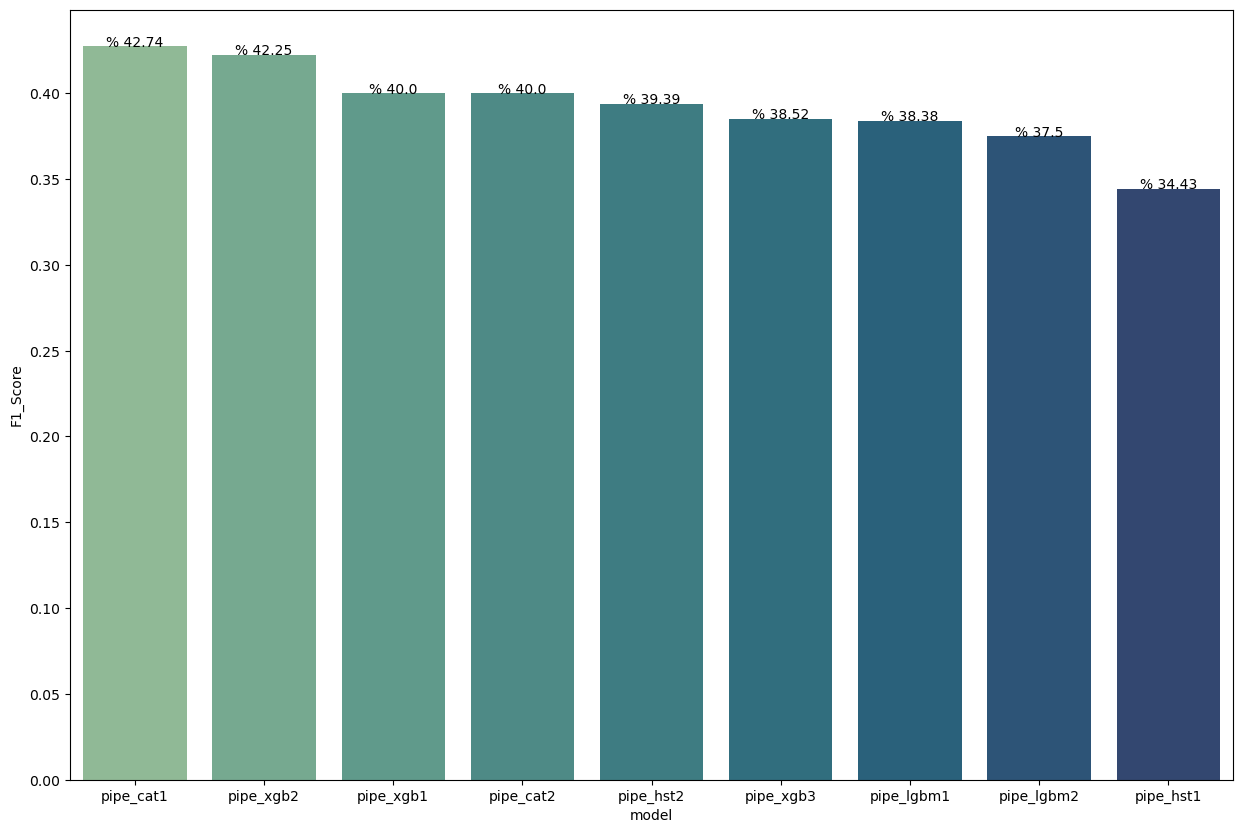

In [56]:
models = []

models.append(("pipe_lgbm1", pipe_lgbm1))
models.append(("pipe_lgbm2", pipe_lgbm2))
models.append(("pipe_xgb1", pipe_xgb1))
models.append(("pipe_xgb2", pipe_xgb2))
models.append(("pipe_xgb3", pipe_xgb3))
models.append(("pipe_hst1", pipe_hst1))
models.append(("pipe_hst2", pipe_hst2))
models.append(("pipe_cat1", pipe_cat1))
models.append(("pipe_cat2", pipe_cat2))


accT = []
names = []

for name, model in models:
    
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accT.append([name, f1_score(y_test, y_pred)])
        
results = pd.DataFrame(accT, columns = ['model', 'F1_Score'])
groupedvalues = results.sort_values(by = 'F1_Score', ascending = False).reset_index()

plt.figure(figsize=(15,10))
g = sns.barplot(x='model', y='F1_Score', data=groupedvalues, palette = "crest")

for index, row in groupedvalues.iterrows():
    g.text(row.name, row.F1_Score, "% {}".format(round(row.F1_Score*100,2)), color='black', ha="center")
    

plt.show()

The Catboost model with overdampling has the highest F1 score. I will also report the recall metric since it indicates the model's discriminative power for the positive class(important class).

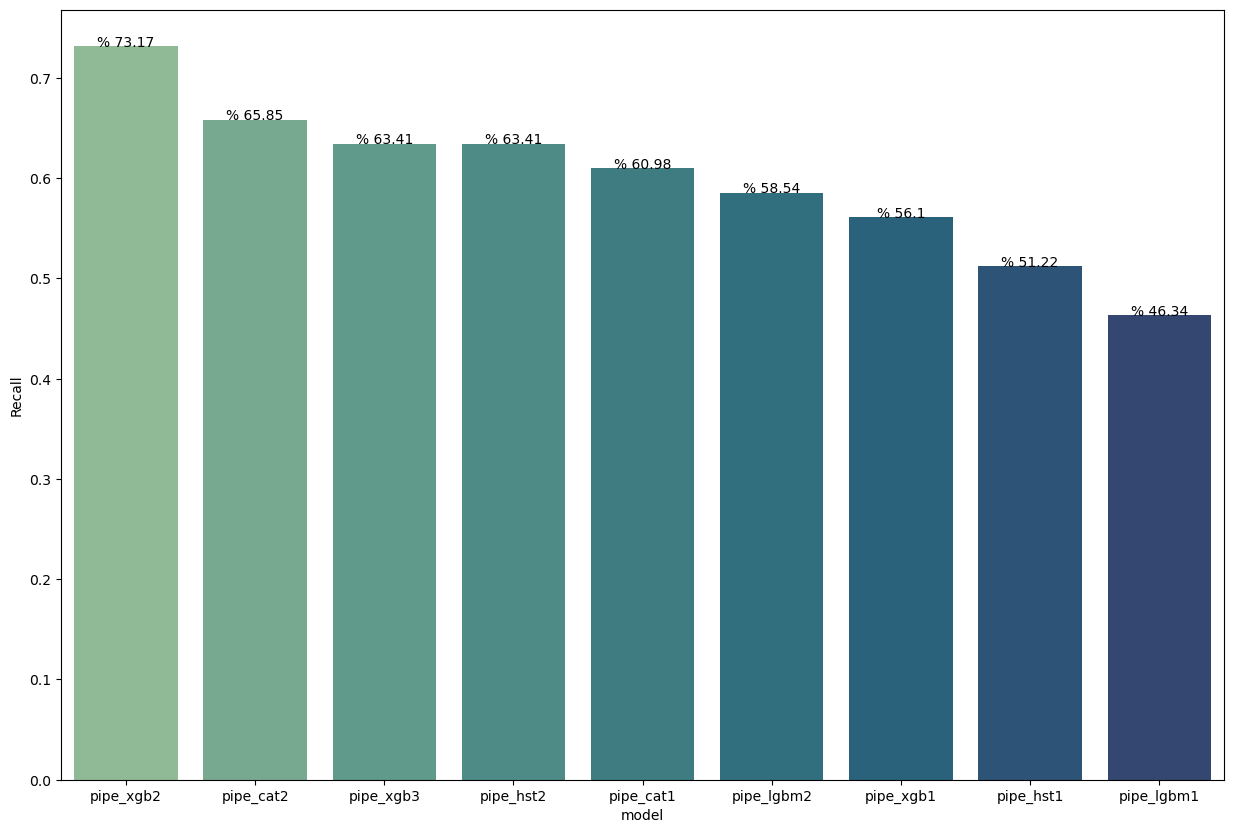

In [57]:
models = []

models.append(("pipe_lgbm1", pipe_lgbm1))
models.append(("pipe_lgbm2", pipe_lgbm2))
models.append(("pipe_xgb1", pipe_xgb1))
models.append(("pipe_xgb2", pipe_xgb2))
models.append(("pipe_xgb3", pipe_xgb3))
models.append(("pipe_hst1", pipe_hst1))
models.append(("pipe_hst2", pipe_hst2))
models.append(("pipe_cat1", pipe_cat1))
models.append(("pipe_cat2", pipe_cat2))



accT = []
names = []

for name, model in models:
    
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accT.append([name, recall_score(y_test, y_pred)])
        
results = pd.DataFrame(accT, columns = ['model', 'Recall'])
groupedvalues = results.sort_values(by = 'Recall', ascending = False).reset_index()

plt.figure(figsize=(15,10))
g = sns.barplot(x='model', y='Recall', data=groupedvalues, palette = "crest")

for index, row in groupedvalues.iterrows():
    g.text(row.name, row.Recall, "% {}".format(round(row.Recall*100,2)), color='black', ha="center")
    

plt.show()

XGBoost with class_weight adjusment has highest recall. 

<a id = "14"></a><br>
# Try Voting Classifier

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

Ensembling models generally ends up with better performance than base models.

In [58]:
estimators = [
    ("pipe_lgbm1", pipe_lgbm1),
    ("pipe_lgbm2", pipe_lgbm2),
    ("pipe_xgb1", pipe_xgb1),
    ("pipe_xgb2", pipe_xgb2),
    ("pipe_xgb3", pipe_xgb3),
    ("pipe_hst1", pipe_hst1),
    ("pipe_hst2", pipe_hst2),
    ("pipe_cat1", pipe_cat1),
    ("pipe_cat2", pipe_cat2)
    
]


In [59]:
from sklearn.ensemble import StackingClassifier

In [60]:
from sklearn.ensemble import VotingClassifier

In [61]:
stacking_clf = VotingClassifier(estimators=estimators, voting = 'soft')

In [62]:
stacking_clf = stacking_clf.fit(X_train, y_train)


In [63]:
y_pred = stacking_clf.predict(X_test)
print(f1_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.448
0.649746192893401
0.6619762351469669
0.6829268292682927


Voting model has better F1 score but less recall.

<a id = "5"></a><br>
# Feature Importances

Let's report performance summary and feature importances for best performing base model on recall metric.

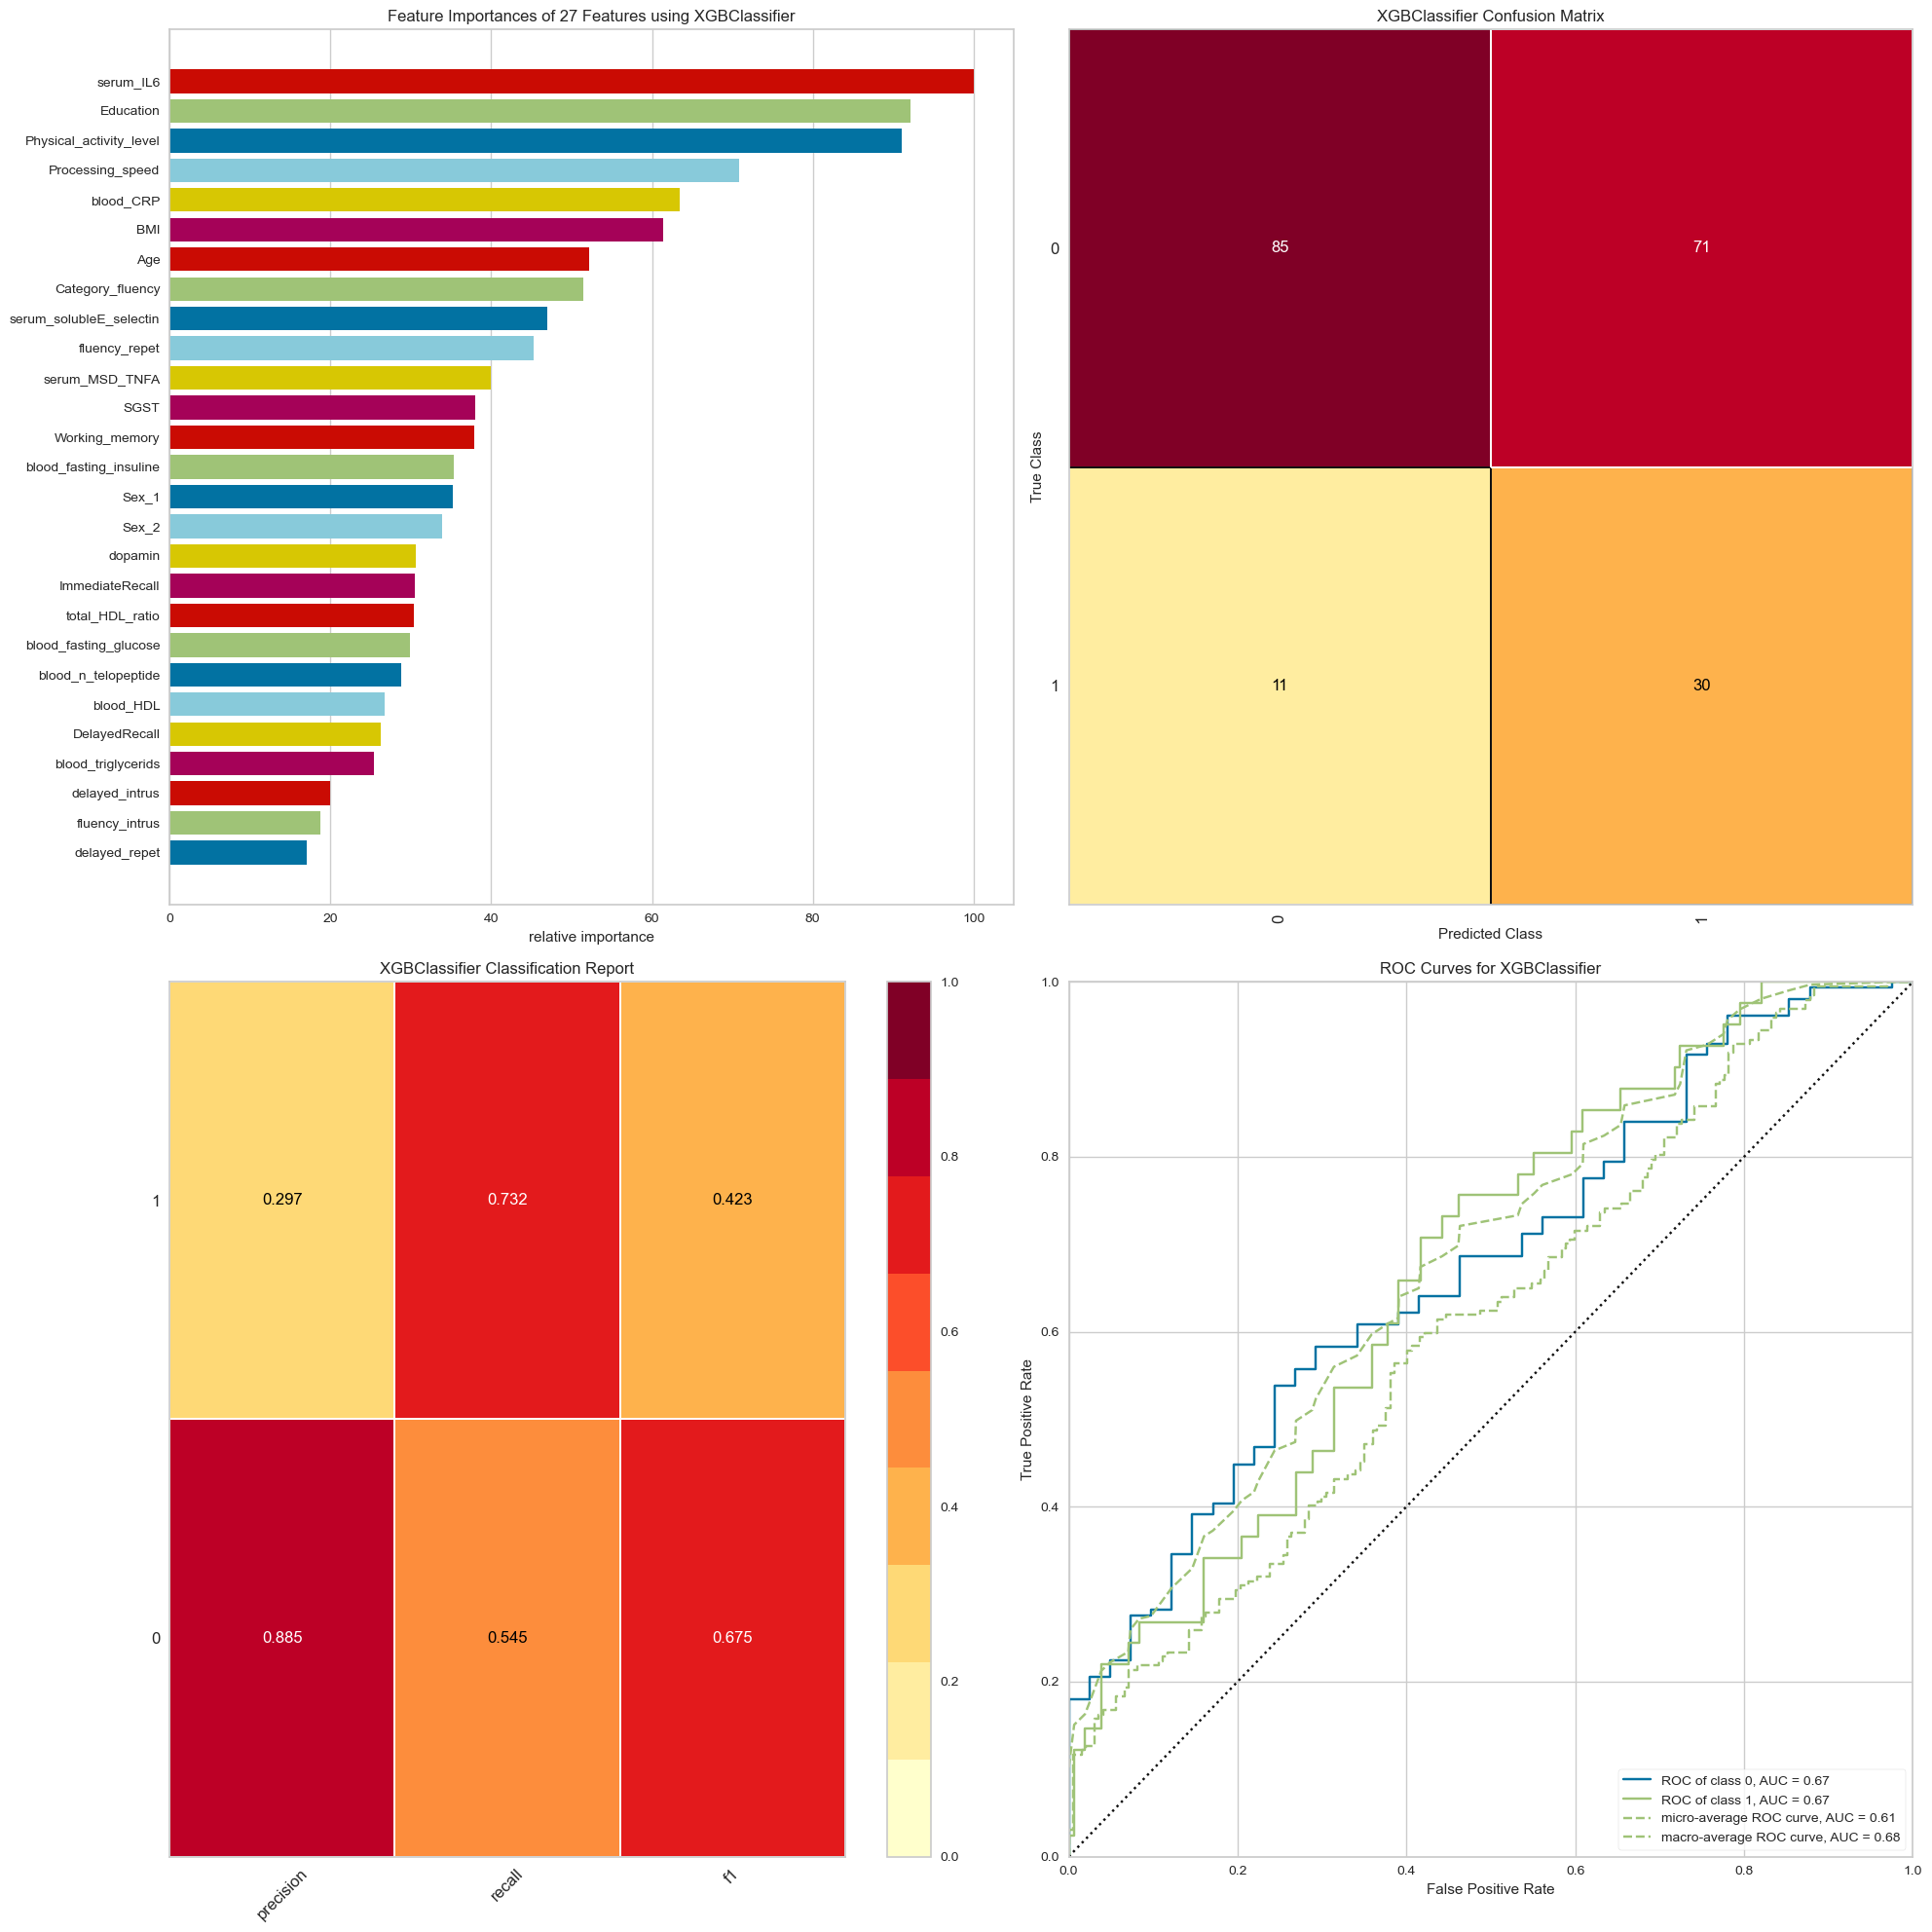

In [64]:
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

model = pipe_xgb2
visualgrid = [
    FeatureImportances(pipe_xgb2.steps[1][1], ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()


Another usefull tool for explaining machine learning models is Shapley values. Shapley values are a widely used approach from  game theory. And they help how to compute and interpet Shapley-based explanations of machine learning models. 

For more information you can check: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [68]:
#pip install shap

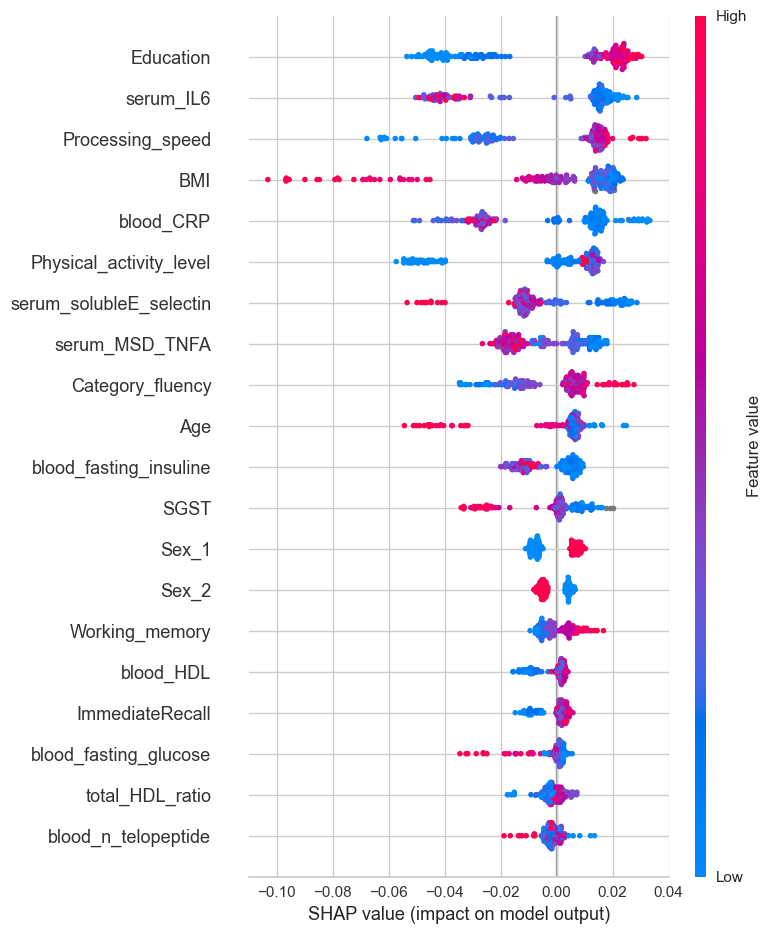

In [82]:
import shap

explainer = shap.Explainer(pipe_xgb2.steps[1][1])


shap_values = explainer.shap_values(X_test)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test)

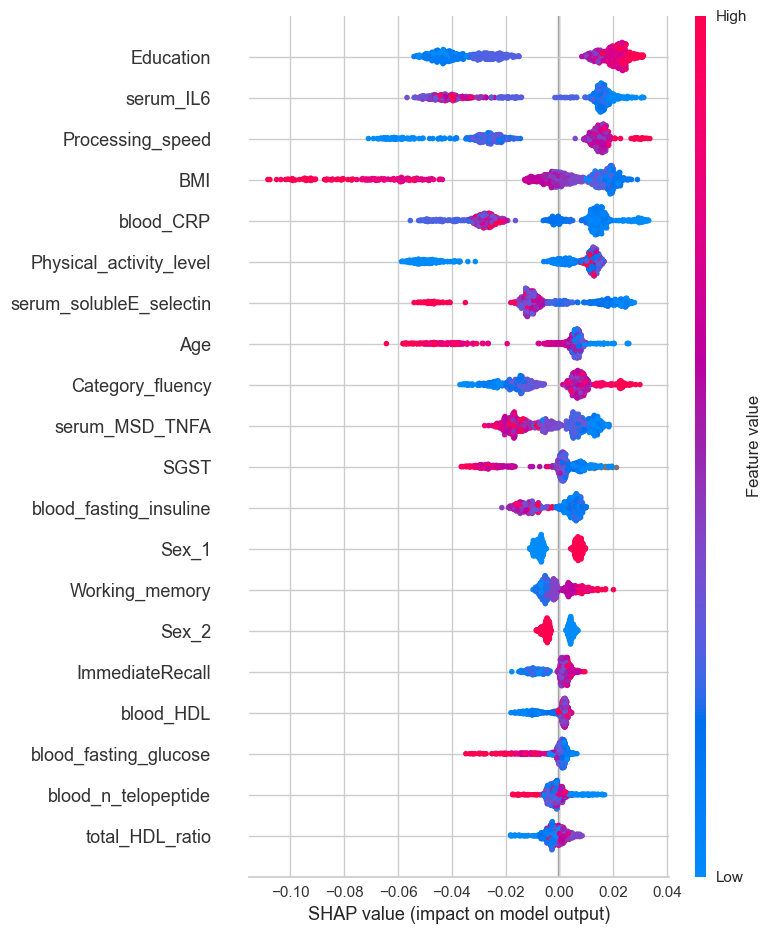

In [83]:
shap_values = explainer.shap_values(X_train)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_train)


Shapley values and XGBoost feature importances quite agreed on what is more importantant and what is not. 

<a id = "5"></a><br>
# AUC comparison

Lastly let's also compare AUC scores for models.

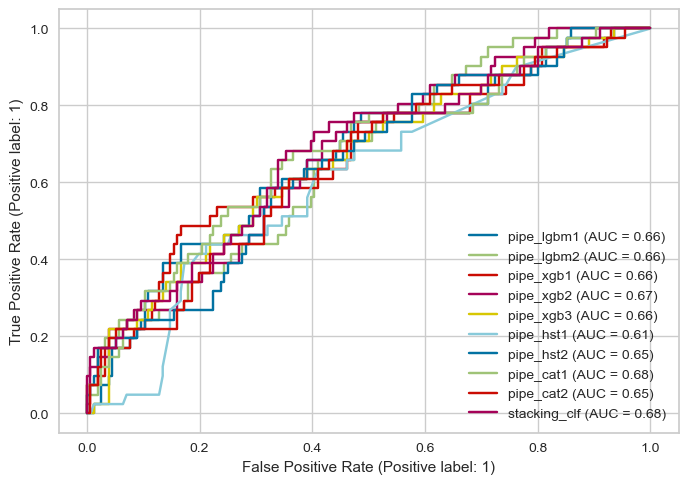

In [65]:
m1 = pipe_lgbm1
m2 = pipe_lgbm2
m3 = pipe_xgb1
m4 = pipe_xgb2
m5 = pipe_xgb3
m6 = pipe_hst1
m7 = pipe_hst2
m8 = pipe_cat1
m9 = pipe_cat2
m10 = stacking_clf


disp = RocCurveDisplay.from_estimator(m1, X_test, y_test, name= 'pipe_lgbm1')
RocCurveDisplay.from_estimator(m2, X_test, y_test, name= 'pipe_lgbm2', ax=disp.ax_);
RocCurveDisplay.from_estimator(m3, X_test, y_test, name= 'pipe_xgb1', ax=disp.ax_);
RocCurveDisplay.from_estimator(m4, X_test, y_test, name= 'pipe_xgb2', ax=disp.ax_);
RocCurveDisplay.from_estimator(m5, X_test, y_test, name= 'pipe_xgb3', ax=disp.ax_);
RocCurveDisplay.from_estimator(m6, X_test, y_test, name= 'pipe_hst1', ax=disp.ax_);
RocCurveDisplay.from_estimator(m7, X_test, y_test,  name= 'pipe_hst2', ax=disp.ax_);
RocCurveDisplay.from_estimator(m8, X_test, y_test,  name= 'pipe_cat1', ax=disp.ax_);
RocCurveDisplay.from_estimator(m9, X_test, y_test,  name= 'pipe_cat2', ax=disp.ax_);
RocCurveDisplay.from_estimator(m10, X_test, y_test,  name= 'stacking_clf', ax=disp.ax_);
